## U.S. Patent Phrase to Phrase Matching
* [Data](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data?select=train.csv)
   - Don Cenkci, Grigor Aslanyan, Ian Wetherbee, jm, Kiran Gunda, Maggie, Scott Beliveau, Will Cukierski. (2022). U.S. Patent Phrase to Phrase Matching. Kaggle. 
 
## Problem Statement and Objective
The objective is to predict the Pearson similarity score, a number between 0 and 1, between phrases extracted from US Patents.
This is a regression problem.
The data also includes the context in which the phrases are to be understood: the first two levels of the [CPC Classification](https://en.wikipedia.org/wiki/Cooperative_Patent_Classification).

## Methodology
Clean up the data, then convert to numerical values, then train a suitable ML model.
Not too much cleaning seems to be required on the phrases themselves, they are already converted to lower case,
don't seem to have contractions, etc.  Will apply some cleanup just in case, but does not seem to be strictly necessary.
We will however remove "stop" words.

Next, we need to convert the phrases into numerical form.   We will convert each phrase into a vector representing
the meanings in the sentences.  The phrases are quite short generally, just a few words, so need to pick an approach suitable 
for that kind of data.   We chose word2vec since it does not require a large corpus to compute frequencies.  On the other hand,
it may not interpret technical terms in the same way as they are used in patents, and will not be conditioned by the CPC
categories.  Ideally we would use the corpus the patents in each category to create embeddings but this is not feasible, so
we will use the word2vec embedding.   Since the cosine similarity of phrases is computed with a dot product between two word
vectors, we will use the pairwise products of the two word vectors as a feature vector input to our model, as well as the cosine
similarity.  Use of the pairwise products will allow a suitable model to learn a weighting of the various elements of the 
vectors suitable for each category.   Including the cosine similarity as a baseline will allow us to build models that can
learn only the residuals conditioned by the categories.  However, while we plan to build a custom model that can take advantage
of this structure, we are also going to try a few other "typical" models for comparison: SVR, random forests, and so on.

The other issue is the CPC category.   There are a lot of CPC categories (over 100 appear in the data), but we decided to use
a one-hot encoding regardless, since this will make "gating" by particular categories easier.
We did not try to break the categories into primary and secondary categories however to avoid spurious matches based on similar
secondary categories with different primary categories.  That is, we don't want A45 and B45 to be treated as similar because the
meaning of "45" is completely different in the A and B primary categories.

For the ML model training, we will try a set of different models and use hyperparameter training to try and find the best
approach.   The best models on the leaderboard seem to have R2 scores in the 0.8 to 0.9 range.

As a note the training data seems to have scores drawn from a small set of possible values: 0, 0.25, 0.5, 0.75, and 1, but this is likely
just an artifact of manual scoring.  We will assume continuous scores in the range 0 to 1 inclusive are acceptable.  However, this
does complicate evaluation of our model, since there will be spurious errors when comparing continuous outputs from our model 
with the test data, e.g. if our model outputs 0.8 and the test data says 0.75, there is an "error" of 0.05 but this is actually
quantization noise in the test data.
Therefore, we will compute errors against both the continuous output from the model and a "quantized" output.

## Libraries

In [1]:
# Only need to run these once
# !python -m pip install tqdm
# !pip install ipywidgets widgetsnbextension pandas-profiling
# !python -m spacy download en_core_web_lg
!pip install scikit-learn-intelex

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Intel optimizations for sklearn (applies to SVC and RandomForest)
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import max_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVR, LinearSVR, SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


The following defines a function that uses the SpaCy `en_core_web_lg` model it to compute a vector
representing all the words in a document.   The "documents" here will be single phrases.

In [3]:
import spacy
nlp = spacy.load('en_core_web_lg')
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return np.array(vec)

## Data

| Label       | Meaning                       | Values                                                                                  |
| ----------- | ----------------------------- | ----------------------------------------------------------------------------------------|
| id          | unique phrase pair identifier | irrelevant for training                                                                 |
| anchor      |	first phrase                  | string                                                                                  |
| target	  | second phrase                 | string                                                                                  |
| context     | CPC Category                  | just primary and secondary, eg. A45                                                     |
| score	      | training target value         | real number between 0 and 1                                                             |

In [4]:
dataset = pd.read_csv('train.csv')
dataset

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


Extract pairs of phrases, convert to word vectors, compute pairwise products and sum of pairwise products (e.g. dot product) as feature vectors.

In [5]:
P = dataset.iloc[:, 1:3].values  # extract pairs of phrases
print(P)

[['abatement' 'abatement of pollution']
 ['abatement' 'act of abating']
 ['abatement' 'active catalyst']
 ...
 ['wood article' 'wooden handle']
 ['wood article' 'wooden material']
 ['wood article' 'wooden substrate']]


In [6]:
# encode strings using word2vec, create pairwise products
W = []
Z = []
for i in range(0,len(P)):
    doc_a = nlp(P[i,0])
    doc_b = nlp(P[i,1])
    vec_a = doc_a.vector 
    vec_b = doc_b.vector
    vec_ab = vec_a * vec_b
    if (doc_a.has_vector and doc_b.has_vector): 
        sim_ab = doc_a.similarity(doc_b)
        W.append(np.concatenate([vec_ab,np.array([sim_ab])]))
        Z.append(np.array([0]))
    else:
        if (not doc_a.has_vector):
            print(f"Source phrase {i} has no embedding: {P[i,0]}")
        if (not doc_b.has_vector):
            print(f"Target phrase {i} has no embedding: {P[i,1]}")
        W.append(np.concatenate([vec_ab,np.array([-1])]))
        Z.append(np.array([1]))
W = np.array(W)
Z = np.array(Z)
print(W)

Target phrase 151 has no embedding: nacl
Target phrase 152 has no embedding: naoh
Source phrase 190 has no embedding: acan
Source phrase 191 has no embedding: acan
Source phrase 192 has no embedding: acan
Source phrase 193 has no embedding: acan
Source phrase 194 has no embedding: acan
Source phrase 195 has no embedding: acan
Source phrase 196 has no embedding: acan
Source phrase 197 has no embedding: acan
Source phrase 198 has no embedding: acan
Source phrase 199 has no embedding: acan
Source phrase 200 has no embedding: acan
Source phrase 201 has no embedding: acan
Target phrase 201 has no embedding: hyalectans
Source phrase 202 has no embedding: acan
Source phrase 203 has no embedding: acan
Target phrase 203 has no embedding: lecticans
Source phrase 204 has no embedding: acan
Source phrase 205 has no embedding: acan
Source phrase 206 has no embedding: acan
Source phrase 207 has no embedding: acan
Source phrase 208 has no embedding: acan
Source phrase 209 has no embedding: acan
Sourc

In [7]:
W.shape

(36473, 301)

In [8]:
Z.shape

(36473, 1)

In [9]:
print(f"Number of phrase pairs with missing word vectors: {np.count_nonzero(Z)}")

Number of phrase pairs with missing word vectors: 1226


Extract column from data giving categories.

In [10]:
dt = dataset.iloc[:,3:4].values
print(dt)

[['A47']
 ['A47']
 ['A47']
 ...
 ['B44']
 ['B44']
 ['B44']]


One-hot encode categories.  Dense output to avoid errors when we combine with word vectors later.

In [11]:
ct = ColumnTransformer(transformers=[('encodeContext', OneHotEncoder(sparse_output=False), [0])])
C = ct.fit_transform(dt)
print(C)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
print(C[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
C.shape

(36473, 106)

Combine word-vector features and category features into a single feature vector per data row.

In [14]:
X = np.concatenate((C,W), axis=1)
print(X)

[[ 0.          0.          0.         ...  0.06085616 -3.37904429
   0.64280009]
 [ 0.          0.          0.         ... -1.98874366 -0.37410259
   0.50056214]
 [ 0.          0.          0.         ... -2.08569288  1.23626184
   0.48700126]
 ...
 [ 0.          0.          0.         ...  0.12720729  5.08476496
   0.57886343]
 [ 0.          0.          0.         ...  2.6827867   0.75554866
   0.76983538]
 [ 0.          0.          0.         ...  2.37303257  0.75986099
   0.70156617]]


In [15]:
X.shape

(36473, 407)

Extract target values.  Multiply by 4 and convert to integers so we can try some multi-label classification approaches as well as regression.

In [16]:
y = dataset.iloc[:,-1].values
print(y)
y = np.array([int(4*s) for s in y])
print(y)

[0.5  0.75 0.25 ... 0.5  0.75 0.5 ]
[2 3 1 ... 2 3 2]


In [17]:
y.shape

(36473,)

## Train/Test Split
We create two splits, one with a large amount of training data and one with a small amount of training data.  The later is necessary for models, like SVR, that don't scale well to large amounts of data.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, stratify=y)

In [19]:
X_train.shape

(29178, 407)

In [20]:
y_train.shape

(29178,)

Splits with a smaller amount of training data for models that can't deal with large amounts of data.

In [21]:
sm_X_train, sm_X_test, sm_y_train, sm_y_test = train_test_split(X, y, test_size = 0.90, random_state = 0, stratify=y)

In [22]:
sm_X_train.shape

(3647, 407)

In [23]:
sm_y_train.shape

(3647,)

Extract last column only for simpler baseline models.

In [24]:
ssm_X_train = sm_X_train[:,-1:]
ssm_X_test = sm_X_test[:,-1:]
s_X_train = X_train[:,-1:]
s_X_test = X_test[:,-1:]

## Feature Scaling
Not strictly needed, but some of the word vector elements are outside the range [-1,1], so just to be safe.  We use separate scalers for the small and large splits to avoid cross-contamination.  We do not scale y; if necessary, we can divide the now-integer y values by 4.0.

In [25]:
# sc = StandardScaler()
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# sm_sc = StandardScaler()
sm_sc = MinMaxScaler()
sm_X_train = sm_sc.fit_transform(sm_X_train)
sm_X_test = sm_sc.transform(sm_X_test)

# ssm_sc = StandardScaler()
ssm_sc = MinMaxScaler()
ssm_X_train = ssm_sc.fit_transform(ssm_X_train)
ssm_X_test = ssm_sc.transform(ssm_X_test)

# s_sc = StandardScaler()
s_sc = MinMaxScaler()
s_X_train = s_sc.fit_transform(s_X_train)
s_X_test = s_sc.transform(s_X_test)

## Evaluation
Function to evaluate results of fitting various models.

In [26]:
def eval_model(model,y_true,X_test):
    y_pred = model.predict(X_test)
    q_pred = np.array([round(s) for s in y_pred])
    y_true_col = y_true.reshape(y_true.shape[0],1)
    y_pred_col = y_pred.reshape(y_pred.shape[0],1)
    q_pred_col = q_pred.reshape(q_pred.shape[0],1)
    print(np.concatenate([y_true_col, y_pred_col, q_pred_col], axis=1))
    print(f"Max error (cts): {max_error(y_true, y_pred)}")
    print(f"RMS error (cts): {root_mean_squared_error(y_true, y_pred)}")
    print(f"Mean absolute error (cts): {mean_absolute_error(y_true, y_pred)}")
    print(f"R2 score (cts): {r2_score(y_true, y_pred)}")
    print(f"Max error (quantized): {max_error(y_true, q_pred)}")
    print(f"RMS error (quantized): {root_mean_squared_error(y_true, q_pred)}")
    print(f"Mean absolute error (quantized): {mean_absolute_error(y_true, q_pred)}")
    print(f"R2 score (quantized): {r2_score(y_true, q_pred)}")
    display = PredictionErrorDisplay(y_true=y_true, y_pred=y_pred)
    display.plot()
    plt.show()
    display = PredictionErrorDisplay(y_true=y_true, y_pred=q_pred)
    display.plot()
    plt.show()
    y_diff = y_true - y_pred
    plt.hist(y_diff,bins = 50)
    plt.title('Histogram of Prediction Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()
    y_diff = y_true - q_pred
    plt.hist(y_diff,bins = 20)
    plt.title('Histogram of Quantized Prediction Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()
    acc = accuracy_score(y_true, q_pred)
    print(f"Accuracy: {acc}")
    cm = confusion_matrix(y_true, q_pred)
    print('Confusion Matrix:')
    print(cm)

## LinearSVR
This model theoretically scales better to large amounts of data than SVR, but is not as accurate.  However, a large number of iterations were required to get anything reasonable so it does not seem to be a good fit for this data.

In [27]:
linear_svr = LinearSVR(C = 1.0, max_iter=1000000, random_state = 0)
linear_svr.fit(X_train, y_train)

LinearSVR(max_iter=1000000, random_state=0)

[[1.         1.3344054  1.        ]
 [0.         1.69903758 2.        ]
 [4.         2.29753298 2.        ]
 ...
 [1.         1.41402985 1.        ]
 [2.         1.57329395 2.        ]
 [0.         1.67794424 2.        ]]
Max error (cts): 4.055767545405987
RMS error (cts): 0.9628017676096754
Mean absolute error (cts): 0.753874365651642
R2 score (cts): 0.13195180937363926
Max error (quantized): 4
RMS error (quantized): 1.0043769871330113
Mean absolute error (quantized): 0.7077450308430432
R2 score (quantized): 0.055365973836455806


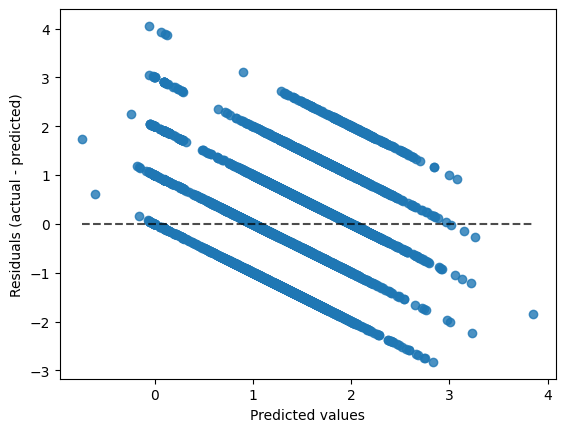

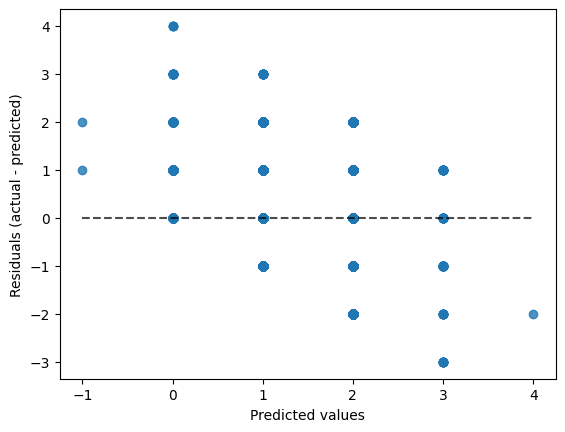

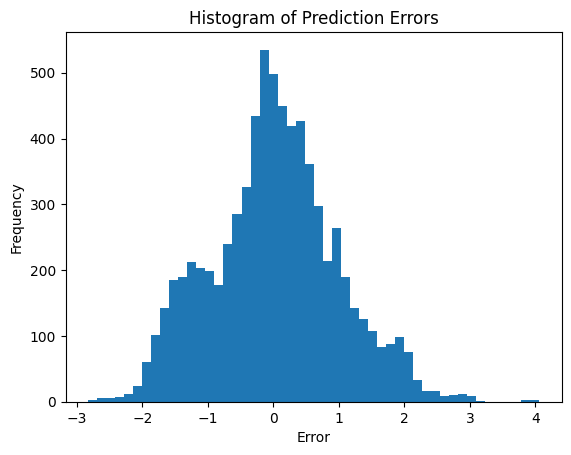

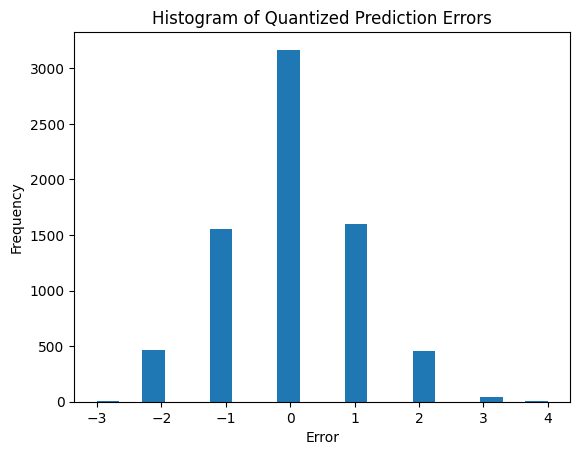

Accuracy: 0.4341329677861549
Confusion Matrix:
[[   0    0    0    0    0    0]
 [   1  111  917  456    9    0]
 [   1  134 1563  597    9    0]
 [   0   84  867 1469   39    1]
 [   0   27  177  578   24    0]
 [   0    4   15  193   19    0]]


In [28]:
eval_model(linear_svr,y_test,X_test)

## SVR

In [29]:
svr = SVR(C = 1.0, max_iter=1000000)
svr.fit(X_train, y_train)

SVR(max_iter=1000000)

[[1.         1.49450006 1.        ]
 [0.         1.59367838 2.        ]
 [4.         2.10636287 2.        ]
 ...
 [1.         1.41975512 1.        ]
 [2.         1.48820942 1.        ]
 [0.         1.62509542 2.        ]]
Max error (cts): 3.2059727820210124
RMS error (cts): 0.8948071322402136
Mean absolute error (cts): 0.6958570932962136
R2 score (cts): 0.2502284580853762
Max error (quantized): 3
RMS error (quantized): 0.9373814752584149
Mean absolute error (quantized): 0.646470185058259
R2 score (quantized): 0.17718384186597114


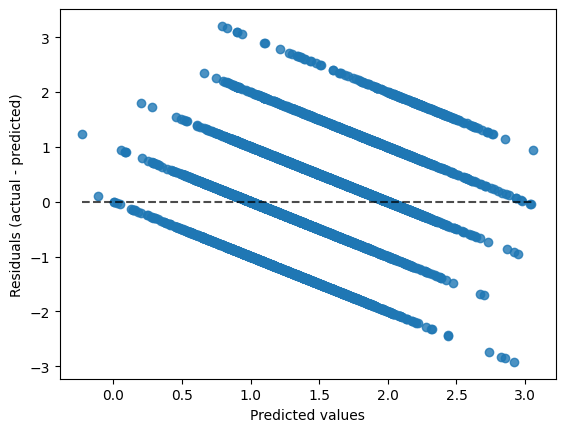

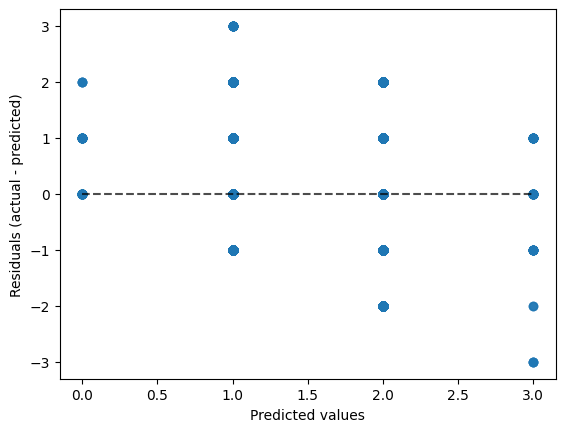

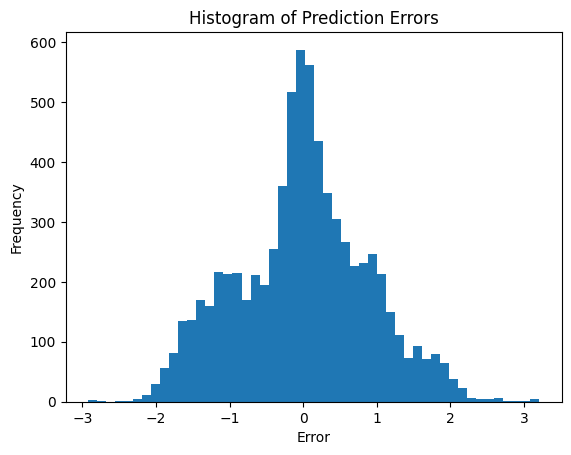

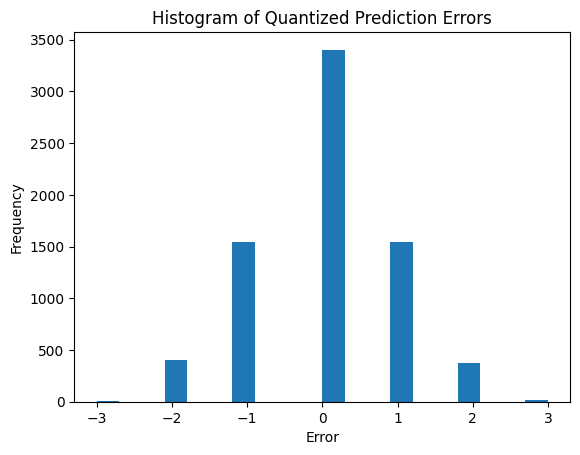

Accuracy: 0.4664838930774503
Confusion Matrix:
[[  41 1051  398    4    0]
 [  27 1797  478    2    0]
 [   4  910 1532   14    0]
 [   0  184  589   33    0]
 [   0   19  190   22    0]]


In [30]:
eval_model(svr,y_test,X_test)

In [31]:
sm_svr = SVR(C = 1.0, max_iter=1000000)
sm_svr.fit(sm_X_train, sm_y_train)

SVR(max_iter=1000000)

[[0.         0.72042803 1.        ]
 [0.         1.03488606 1.        ]
 [2.         1.06654563 1.        ]
 ...
 [2.         1.4314472  1.        ]
 [1.         1.04278865 1.        ]
 [0.         1.44428659 1.        ]]
Max error (cts): 3.6143815659418146
RMS error (cts): 0.946851901833293
Mean absolute error (cts): 0.7412048846585693
R2 score (cts): 0.16042207925684826
Max error (quantized): 4
RMS error (quantized): 0.9815205980810806
Mean absolute error (quantized): 0.6864071163102419
R2 score (quantized): 0.09781472709513916


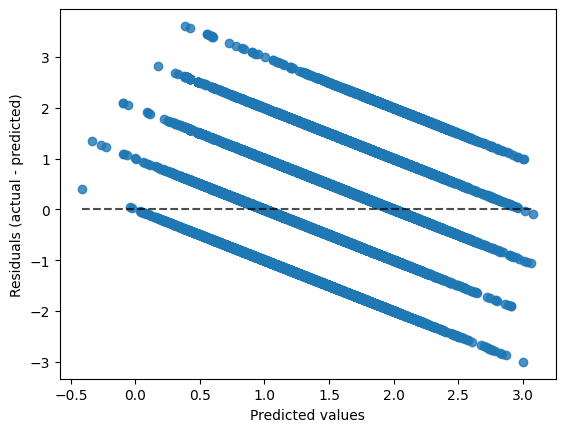

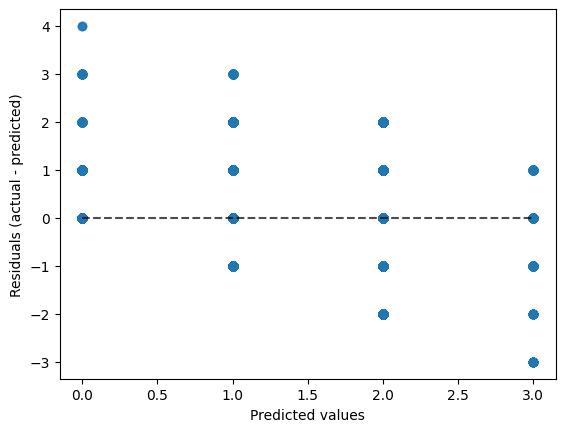

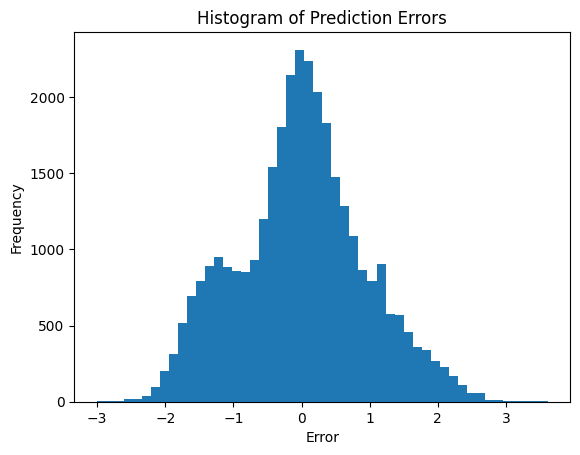

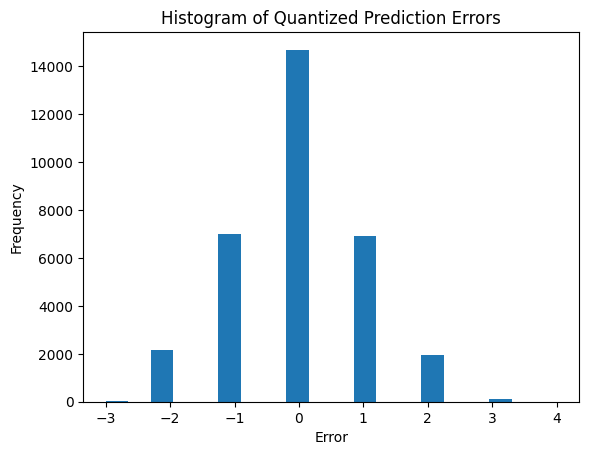

Accuracy: 0.4474501919210382
Confusion Matrix:
[[ 205 4379 2117   23    0]
 [ 238 7606 2498   25    0]
 [  79 4104 6782  105    0]
 [  44  992 2495   95    0]
 [   2   79  883   75    0]]


In [32]:
eval_model(sm_svr,sm_y_test,sm_X_test)

In [33]:
ssm_svr = SVR(C = 1.0, max_iter=1000000)
ssm_svr.fit(ssm_X_train, sm_y_train)

SVR(max_iter=1000000)

[[0.         0.92024793 1.        ]
 [0.         0.90860199 1.        ]
 [2.         0.90948815 1.        ]
 ...
 [2.         2.10091287 2.        ]
 [1.         1.05304287 1.        ]
 [0.         1.37131026 1.        ]]
Max error (cts): 3.100663444335346
RMS error (cts): 0.9262297086447601
Mean absolute error (cts): 0.7021518189668133
R2 score (cts): 0.19659540576151524
Max error (quantized): 3
RMS error (quantized): 0.9573873341153638
Mean absolute error (quantized): 0.6730031072929995
R2 score (quantized): 0.14163450255624044


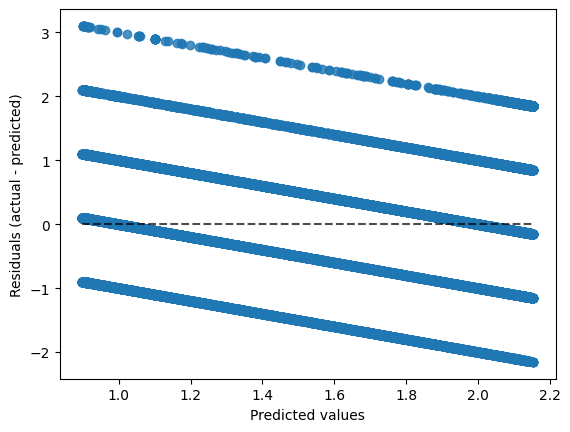

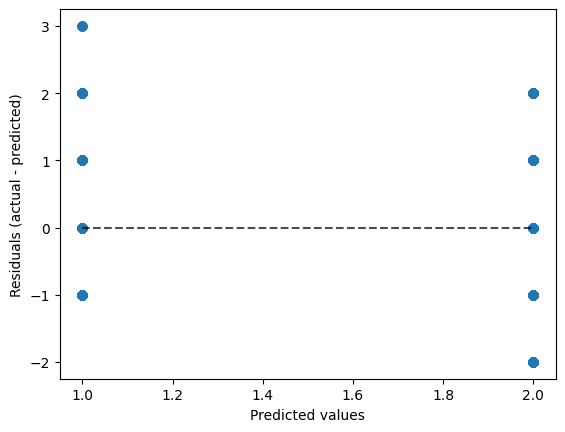

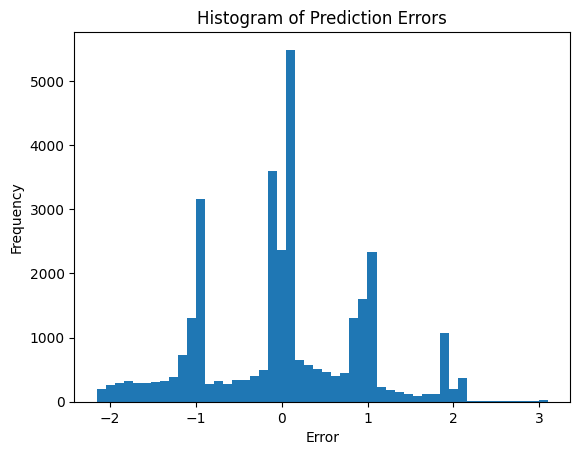

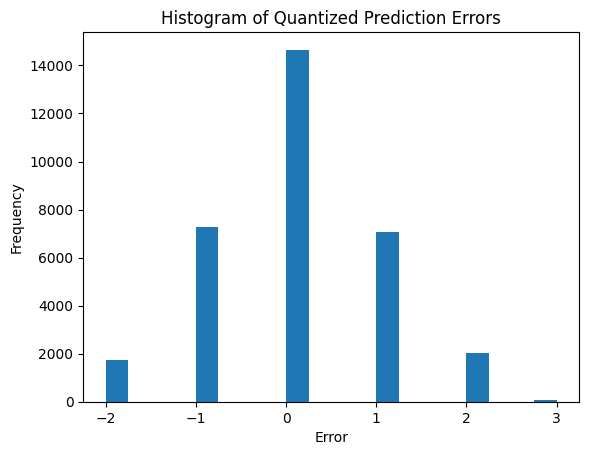

Accuracy: 0.44641442758788763
Confusion Matrix:
[[   0 5001 1723    0    0]
 [   0 8107 2260    0    0]
 [   0 4523 6547    0    0]
 [   0 1080 2546    0    0]
 [   0   78  961    0    0]]


In [34]:
eval_model(ssm_svr,sm_y_test,ssm_X_test)

In [35]:
s_svr = SVR(C = 1.0, max_iter=1000000)
s_svr.fit(s_X_train, y_train)

SVR(max_iter=1000000)

[[1.         1.59166639 2.        ]
 [0.         1.6334629  2.        ]
 [4.         2.14784304 2.        ]
 ...
 [1.         1.37348175 1.        ]
 [2.         1.52793225 2.        ]
 [0.         1.92891301 2.        ]]
Max error (cts): 3.0999941590506808
RMS error (cts): 0.9120650414173384
Mean absolute error (cts): 0.6959873298287814
R2 score (cts): 0.2210282674278249
Max error (quantized): 3
RMS error (quantized): 0.9451002753678271
Mean absolute error (quantized): 0.6656614119259767
R2 score (quantized): 0.16357720960977662


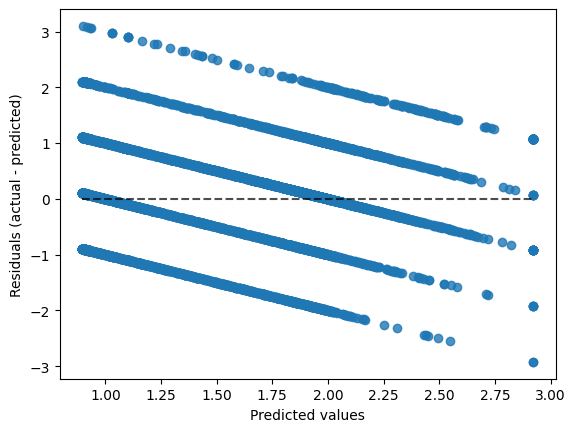

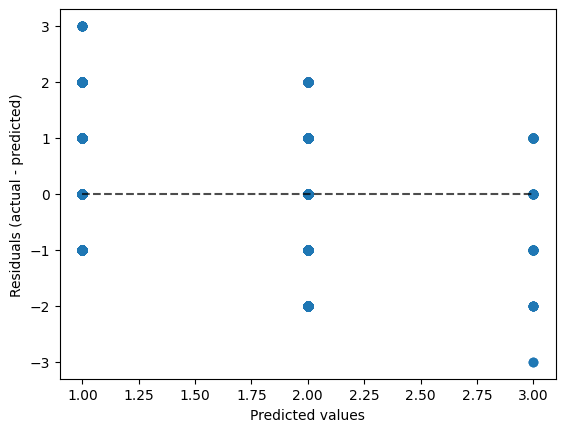

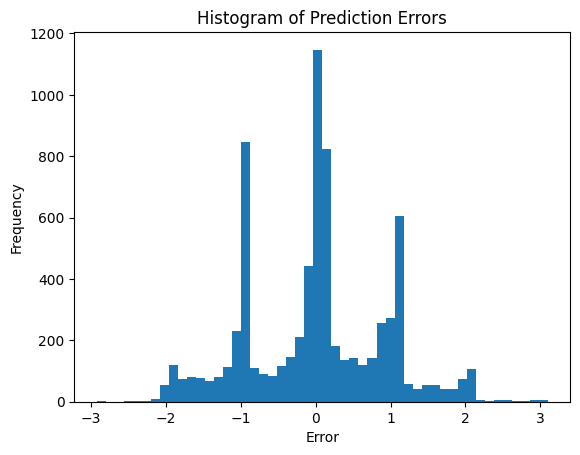

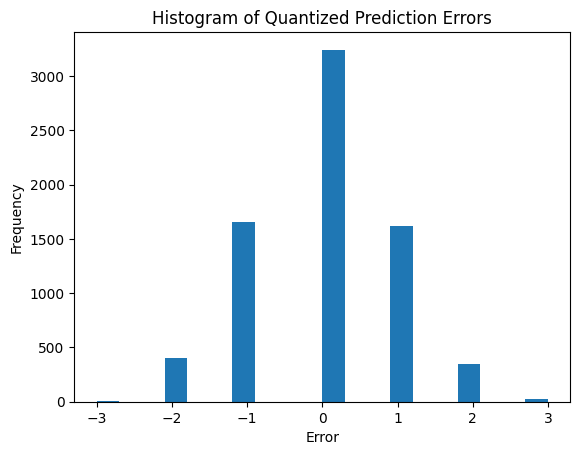

Accuracy: 0.4446881425633996
Confusion Matrix:
[[   0 1096  395    3    0]
 [   0 1785  509   10    0]
 [   0  990 1423   47    0]
 [   0  219  551   36    0]
 [   0   22  131   78    0]]


In [36]:
eval_model(s_svr,y_test,s_X_test)

### Grid Search

In [37]:
cstep = 0.1
gstep = 0.1
parameters = [{'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['linear'], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['poly'], 'degree': [2, 3, 4], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['sigmoid'], 'gamma': ['scale'], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['sigmoid'], 'gamma': np.arange(gstep,1+gstep,gstep), 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['rbf'], 'gamma': ['scale'], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['rbf'], 'gamma': np.arange(gstep,1+gstep,gstep), 'max_iter': [100000]}]
svr_grid_search = GridSearchCV(estimator = svr,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 4)
svr_grid_search.fit(X_train, y_train)
best_score = svr_grid_search.best_score_
best_parameters = svr_grid_search.best_params_
cv_results = pd.DataFrame(svr_grid_search.cv_results_)
print("Best Score: {:.2f}".format(best_score*100))
print("Best Parameters:", best_parameters)
print("Cross-Validation Results:\n", cv_results)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
[CV 4/5] END C=0.1, kernel=linear, max_iter=100000;, score=0.120 total time=  28.7s
[CV 3/5] END C=0.7000000000000001, kernel=linear, max_iter=100000;, score=0.138 total time=  37.2s
[CV 1/5] END C=0.2, degree=2, kernel=poly, max_iter=100000;, score=0.162 total time=  28.7s
[CV 2/5] END C=0.30000000000000004, degree=3, kernel=poly, max_iter=100000;, score=0.231 total time=  37.0s
[CV 3/5] END C=0.5, degree=2, kernel=poly, max_iter=100000;, score=0.183 total time=  32.1s


/home/mmccool/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END C=0.30000000000000004, kernel=linear, max_iter=100000;, score=0.124 total time=  31.9s
[CV 2/5] END C=0.8, kernel=linear, max_iter=100000;, score=0.111 total time=  39.7s
[CV 2/5] END C=0.2, degree=3, kernel=poly, max_iter=100000;, score=0.215 total time=  33.7s
[CV 3/5] END C=0.4, degree=2, kernel=poly, max_iter=100000;, score=0.174 total time=  31.1s
[CV 3/5] END C=0.5, degree=3, kernel=poly, max_iter=100000;, score=0.260 total time=  40.8s
[CV 3/5] END C=0.1, kernel=linear, max_iter=100000;, score=0.140 total time=  28.9s
[CV 4/5] END C=0.7000000000000001, kernel=linear, max_iter=100000;, score=0.119 total time=  36.7s
[CV 5/5] END C=0.1, degree=4, kernel=poly, max_iter=100000;, score=0.264 total time=  40.8s
[CV 4/5] END C=0.4, degree=2, kernel=poly, max_iter=100000;, score=0.160 total time=  30.3s
[CV 5/5] END C=0.5, degree=3, kernel=poly, max_iter=100000;, score=0.258 total time=  41.3s
[CV 5/5] END C=0.1, kernel=linear, max_iter=100000;, score=0.124 total time=  31.

[[1.         1.98665738 2.        ]
 [0.         1.24569731 1.        ]
 [4.         1.8320951  2.        ]
 ...
 [1.         1.44197956 1.        ]
 [2.         1.59109894 2.        ]
 [0.         1.07620356 1.        ]]
Max error (cts): 3.1668348100126553
RMS error (cts): 0.839941268542974
Mean absolute error (cts): 0.6447414093277989
R2 score (cts): 0.33935535667905925
Max error (quantized): 3
RMS error (quantized): 0.8839440558654894
Mean absolute error (quantized): 0.5935572309801234
R2 score (quantized): 0.26832260509142525


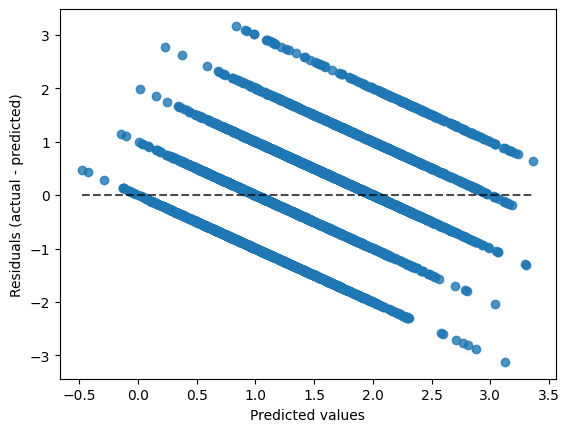

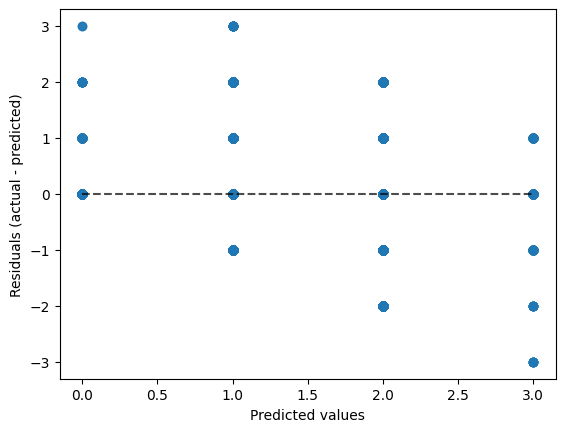

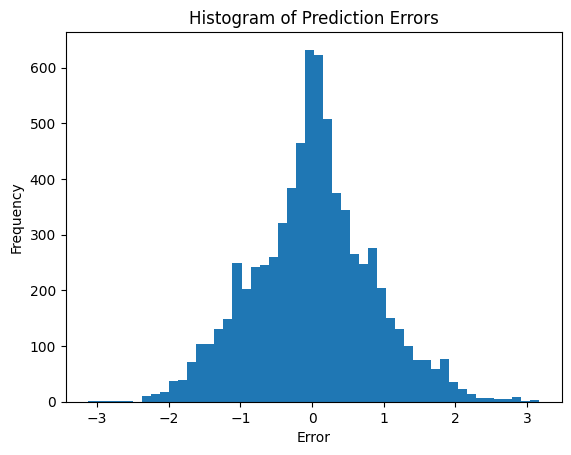

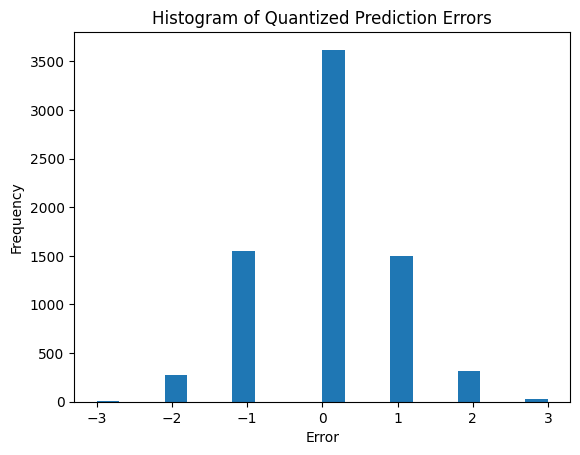

Accuracy: 0.4962302947224126
Confusion Matrix:
[[ 188 1029  270    7    0]
 [  89 1764  443    8    0]
 [  13  820 1548   79    0]
 [   2  168  516  120    0]
 [   0   21  136   74    0]]


In [38]:
eval_model(svr_grid_search,y_test,X_test)

## Decision Trees/Random Forest

In [39]:
rf = RandomForestRegressor(n_estimators = 100, criterion = 'friedman_mse', random_state = 0)
rf.fit(X_train, y_train)

[CV 2/5] END C=1.0, gamma=0.1, kernel=rbf, max_iter=100000;, score=0.242 total time=  36.0s
[CV 2/5] END C=1.0, gamma=0.5, kernel=rbf, max_iter=100000;, score=0.322 total time=  59.2s
[CV 2/5] END C=0.8, gamma=0.4, kernel=rbf, max_iter=100000;, score=0.306 total time=  52.9s
[CV 3/5] END C=0.8, gamma=1.0, kernel=rbf, max_iter=100000;, score=0.318 total time=  56.4s
[CV 3/5] END C=0.9, gamma=0.6, kernel=rbf, max_iter=100000;, score=0.327 total time=  56.7s
[CV 3/5] END C=1.0, gamma=0.1, kernel=rbf, max_iter=100000;, score=0.253 total time=  35.9s
[CV 5/5] END C=1.0, gamma=0.5, kernel=rbf, max_iter=100000;, score=0.323 total time=  59.3s
[CV 3/5] END C=0.9, gamma=0.1, kernel=rbf, max_iter=100000;, score=0.249 total time=  34.8s
[CV 3/5] END C=0.9, gamma=0.4, kernel=rbf, max_iter=100000;, score=0.316 total time=  54.0s
[CV 4/5] END C=0.9, gamma=1.0, kernel=rbf, max_iter=100000;, score=0.306 total time=  58.8s
[CV 4/5] END C=1.0, gamma=0.6, kernel=rbf, max_iter=100000;, score=0.312 total t

RandomForestRegressor(criterion='friedman_mse', random_state=0)

[[1.   1.34 1.  ]
 [0.   1.27 1.  ]
 [4.   3.31 3.  ]
 ...
 [1.   1.26 1.  ]
 [2.   1.16 1.  ]
 [0.   1.46 1.  ]]
Max error (cts): 3.148
RMS error (cts): 0.8123684870988966
Mean absolute error (cts): 0.6278043479349662
R2 score (cts): 0.3820174463062318
Max error (quantized): 3
RMS error (quantized): 0.8513183744288411
Mean absolute error (quantized): 0.5835503769705278
R2 score (quantized): 0.3213371251084851


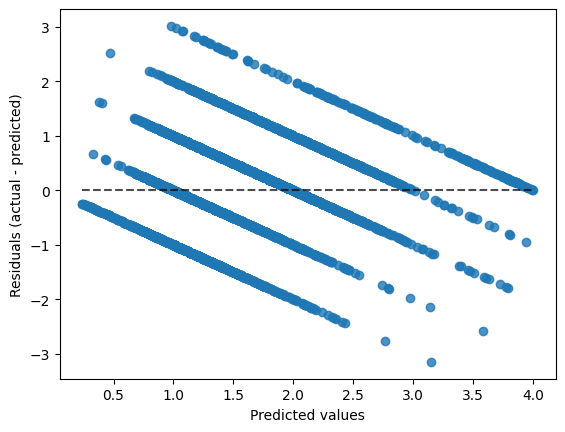

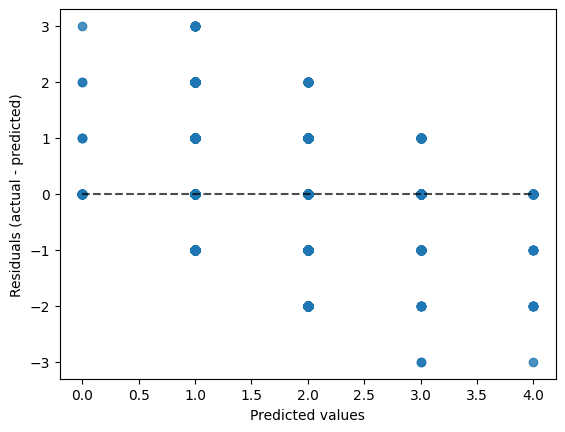

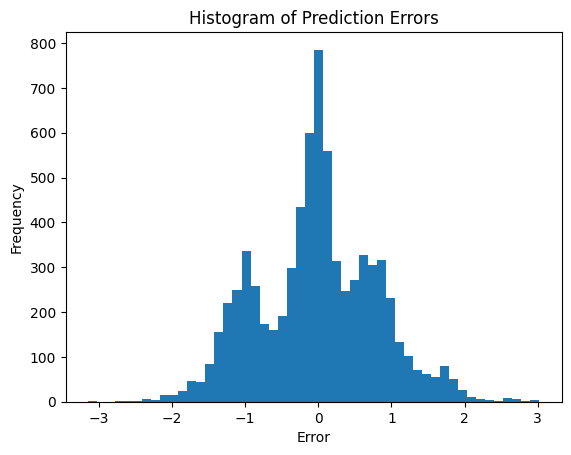

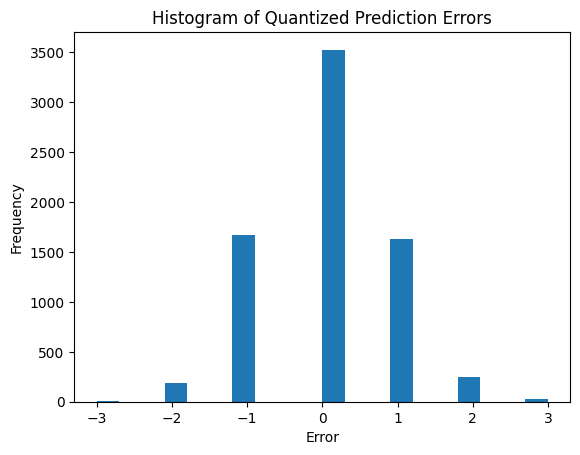

Accuracy: 0.48348183687457164
Confusion Matrix:
[[  60 1260  172    2    0]
 [   3 1973  320    7    1]
 [   2 1087 1276   88    7]
 [   1  193  465  140    7]
 [   0   22   56   75   78]]


In [40]:
eval_model(rf,y_test,X_test)

In [41]:
s_rf = RandomForestRegressor(n_estimators = 100, criterion = 'friedman_mse', random_state = 0)
s_rf.fit(s_X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', random_state=0)

[[1.         0.70666667 1.        ]
 [0.         2.45       2.        ]
 [4.         3.4        3.        ]
 ...
 [1.         0.7        1.        ]
 [2.         0.97       1.        ]
 [0.         2.52       3.        ]]
Max error (cts): 3.9466666666666663
RMS error (cts): 1.0258108892439817
Mean absolute error (cts): 0.7994374335417143
R2 score (cts): 0.014617856201030954
Max error (quantized): 4
RMS error (quantized): 1.0772111327578053
Mean absolute error (quantized): 0.772446881425634
R2 score (quantized): -0.08660511366685708


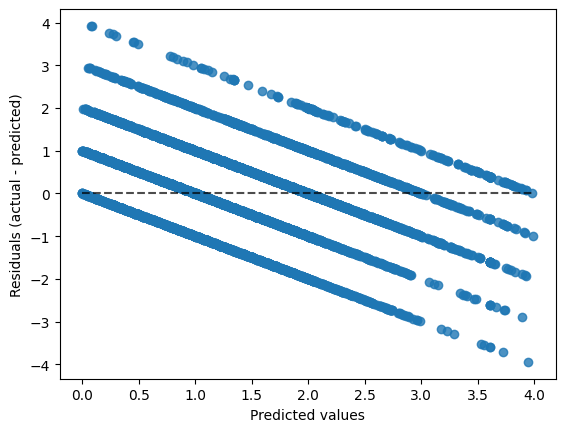

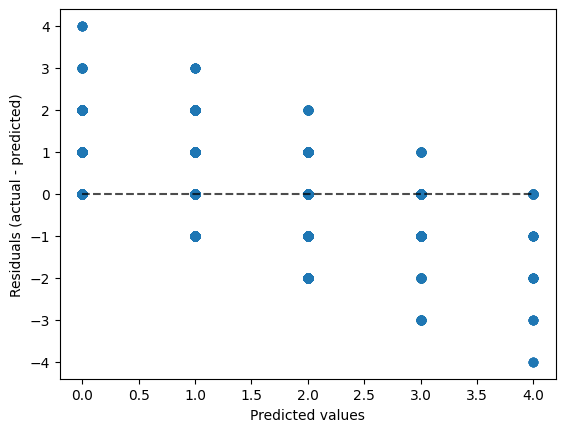

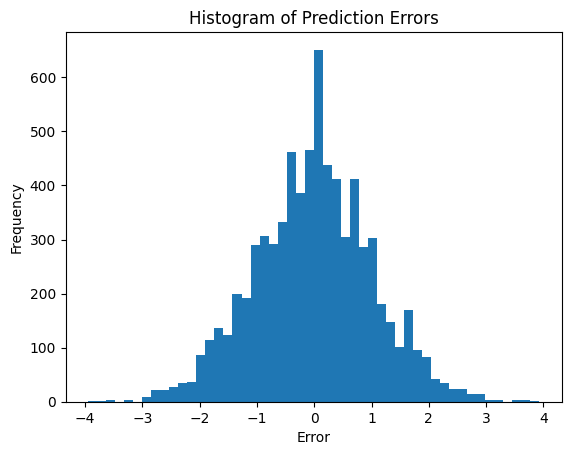

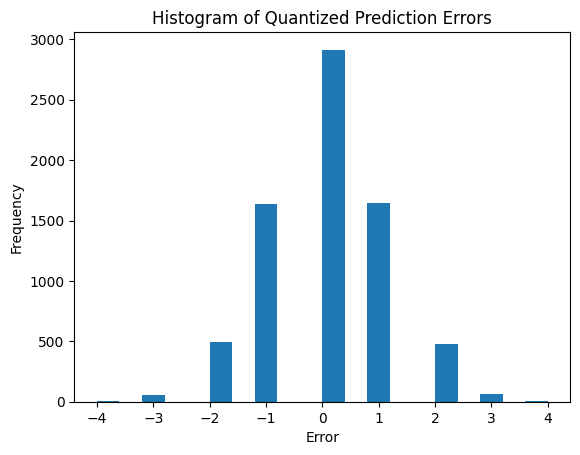

Accuracy: 0.3994516792323509
Confusion Matrix:
[[ 274  760  404   50    6]
 [ 349 1265  615   67    8]
 [ 195  904 1099  237   25]
 [  42  228  332  183   21]
 [   8   19   55   56   93]]


In [42]:
eval_model(s_rf,y_test,s_X_test)

In [43]:
ssm_rf = RandomForestRegressor(n_estimators = 500, criterion = 'friedman_mse', random_state = 0)
ssm_rf.fit(ssm_X_train, sm_y_train)

RandomForestRegressor(criterion='friedman_mse', n_estimators=500,
                      random_state=0)

[[0.    1.832 2.   ]
 [0.    1.372 1.   ]
 [2.    1.01  1.   ]
 ...
 [2.    2.13  2.   ]
 [1.    0.742 1.   ]
 [0.    1.776 2.   ]]
Max error (cts): 3.892
RMS error (cts): 1.0720854160260256
Mean absolute error (cts): 0.850037483766454
R2 score (cts): -0.07635534967214475
Max error (quantized): 4
RMS error (quantized): 1.1241547390881046
Mean absolute error (quantized): 0.8331505513921891
R2 score (quantized): -0.18344775094587473


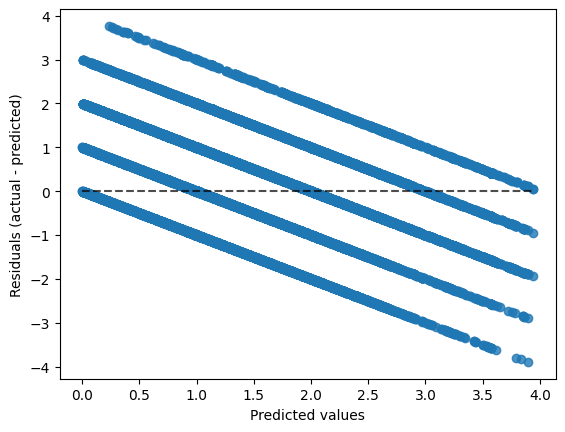

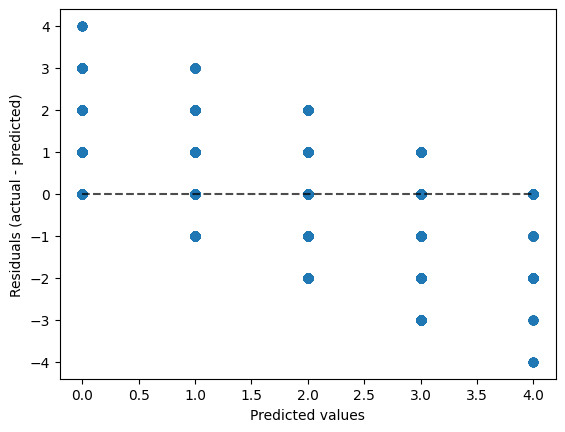

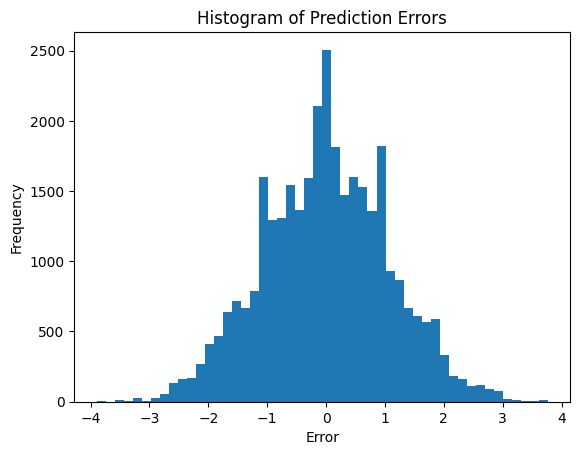

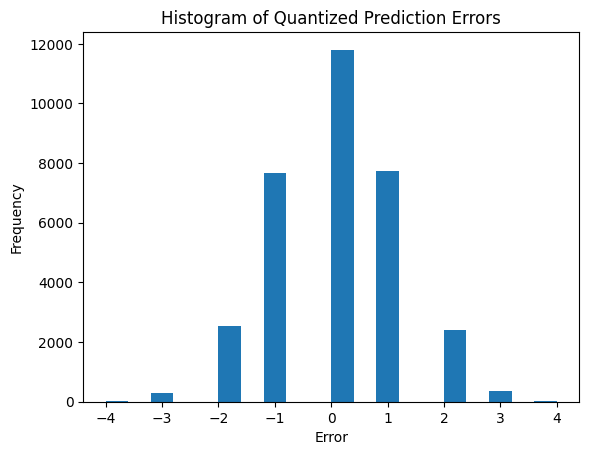

Accuracy: 0.3595625418875282
Confusion Matrix:
[[1048 3473 1942  244   17]
 [1650 5446 2824  414   33]
 [ 993 4284 4357 1253  183]
 [ 248 1100 1560  608  110]
 [  17  114  314  250  344]]


In [44]:
eval_model(ssm_rf,sm_y_test,ssm_X_test)

## Histogram Gradient Boosting

In [45]:
hgb = HistGradientBoostingRegressor(max_iter = 500, random_state = 0)
hgb.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=500, random_state=0)

[[1.         1.3676115  1.        ]
 [0.         1.04468828 1.        ]
 [4.         2.71713789 3.        ]
 ...
 [1.         1.10165969 1.        ]
 [2.         1.21464449 1.        ]
 [0.         1.22419813 1.        ]]
Max error (cts): 3.145128112006833
RMS error (cts): 0.8035073290223524
Mean absolute error (cts): 0.6336990424442216
R2 score (cts): 0.39542558654213067
Max error (quantized): 3
RMS error (quantized): 0.8444472501747056
Mean absolute error (quantized): 0.5858807402330364
R2 score (quantized): 0.3322481038044902


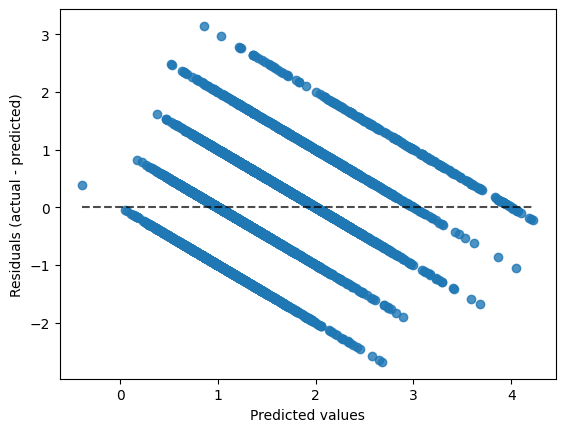

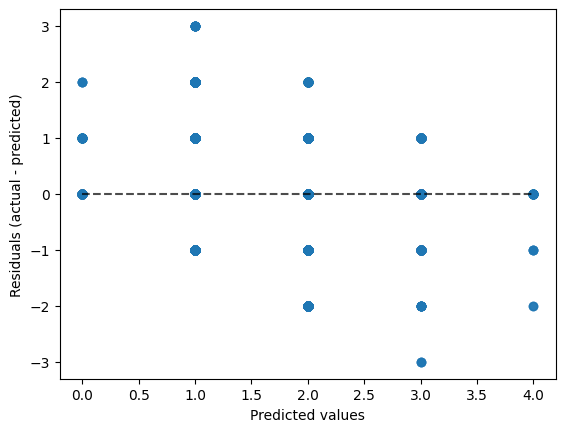

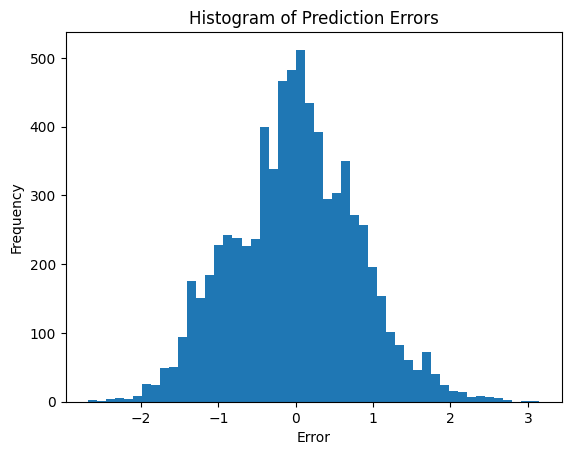

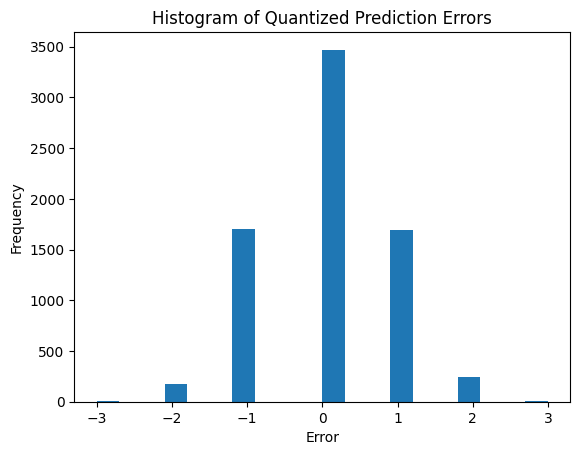

Accuracy: 0.4756682659355723
Confusion Matrix:
[[ 105 1220  166    3    0]
 [  45 1887  361   11    0]
 [   4 1040 1297  117    2]
 [   0  176  492  134    4]
 [   0   12   60  112   47]]


In [46]:
eval_model(hgb,y_test,X_test)

In [47]:
s_hgb = HistGradientBoostingRegressor(max_iter = 500, random_state = 0)
s_hgb.fit(s_X_train, y_train)

HistGradientBoostingRegressor(max_iter=500, random_state=0)

[[1.         1.30707441 1.        ]
 [0.         1.31282365 1.        ]
 [4.         2.22241939 2.        ]
 ...
 [1.         1.15851156 1.        ]
 [2.         1.45567823 1.        ]
 [0.         1.77803636 2.        ]]
Max error (cts): 3.018027103261314
RMS error (cts): 0.9020603265307723
Mean absolute error (cts): 0.705961406395739
R2 score (cts): 0.23802408619272009
Max error (quantized): 3
RMS error (quantized): 0.9410303075636064
Mean absolute error (quantized): 0.6708704592186429
R2 score (quantized): 0.17076561910361532


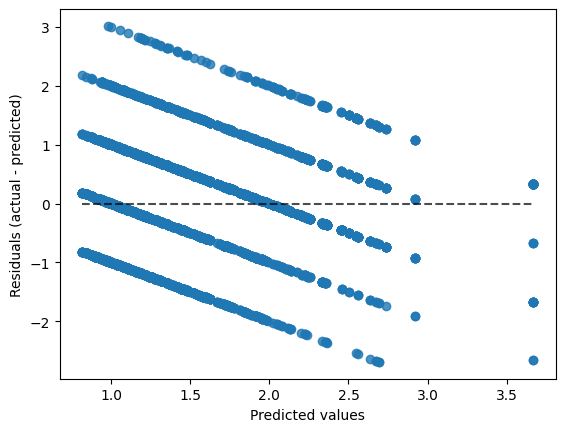

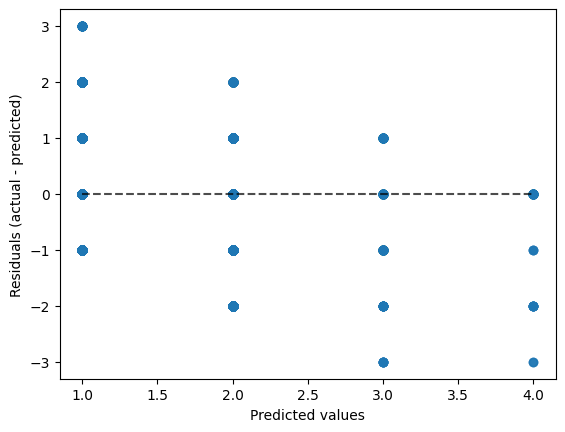

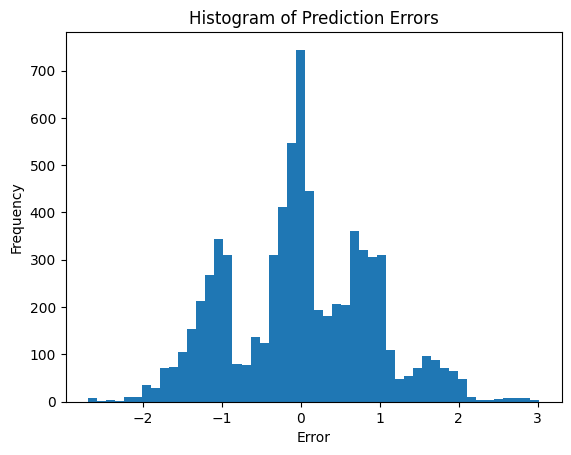

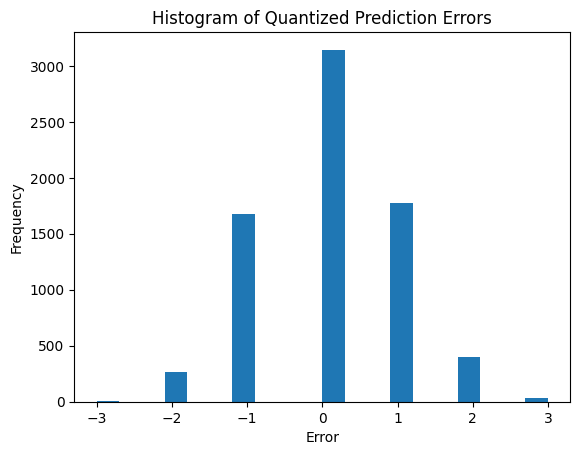

Accuracy: 0.43098012337217273
Confusion Matrix:
[[   0 1247  240    7    0]
 [   0 1933  354   15    2]
 [   0 1288 1093   71    8]
 [   0  310  430   63    3]
 [   0   31   90   55   55]]


In [48]:
eval_model(s_hgb,y_test,s_X_test)

In [49]:
ssm_hgb = HistGradientBoostingRegressor(max_iter = 500, random_state = 0)
ssm_hgb.fit(ssm_X_train, sm_y_train)

HistGradientBoostingRegressor(max_iter=500, random_state=0)

[[0.         0.85897572 1.        ]
 [0.         1.30995305 1.        ]
 [2.         1.30995305 1.        ]
 ...
 [2.         2.19556111 2.        ]
 [1.         0.86233218 1.        ]
 [0.         1.02673163 1.        ]]
Max error (cts): 3.3242902362544533
RMS error (cts): 0.9296845254777922
Mean absolute error (cts): 0.737680545649932
R2 score (cts): 0.19059086459137242
Max error (quantized): 3
RMS error (quantized): 0.9597549647677115
Mean absolute error (quantized): 0.6929568025345763
R2 score (quantized): 0.13738375610851639


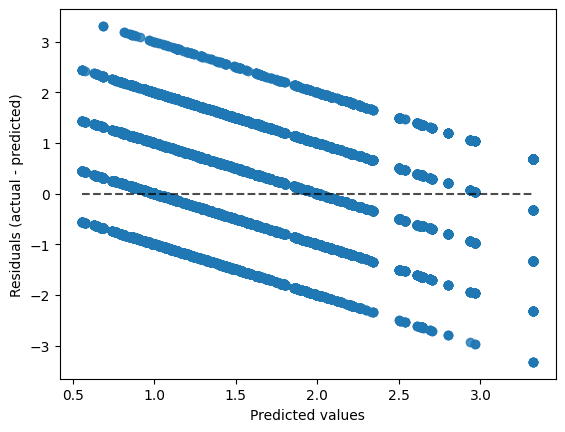

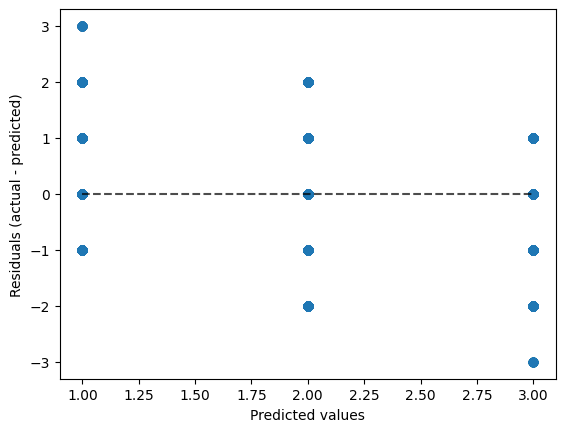

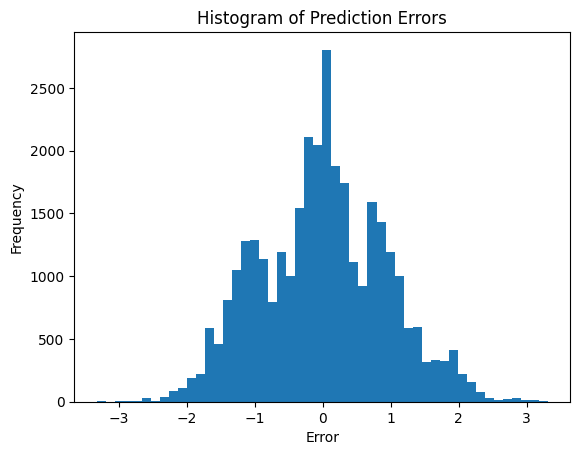

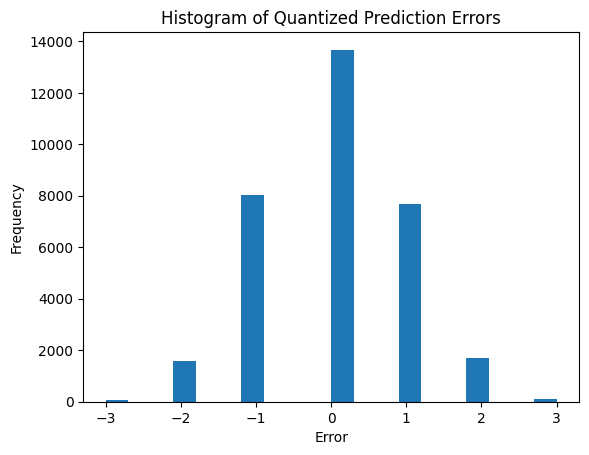

Accuracy: 0.4165295802108085
Confusion Matrix:
[[   0 5312 1363   49    0]
 [   0 8458 1697  212    0]
 [   0 5440 4626 1004    0]
 [   0 1401 1636  589    0]
 [   0  102  316  621    0]]


In [50]:
eval_model(ssm_hgb,sm_y_test,ssm_X_test)

## Classifiers
The training target is heavily quantized, so rather than treating the fitting problem as a regression we can treat it as a multiclass classification problem.
It is likely this will also give us better results if the human scorers were using different criteria for each possible score.
Again we can try several different approaches.   We've already converted the target to integers to make this approach possible.

### SVC

In [51]:
ovr_svc = OneVsRestClassifier(SVC(C = 1.0, max_iter=1000000, random_state=0))
ovr_svc.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(max_iter=1000000, random_state=0))

[[1 1 1]
 [0 2 2]
 [4 2 2]
 ...
 [1 1 1]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 1.0208921094361436
Mean absolute error (cts): 0.6869088416723783
R2 score (cts): 0.024045046756158928
Max error (quantized): 4
RMS error (quantized): 1.0208921094361436
Mean absolute error (quantized): 0.6869088416723783
R2 score (quantized): 0.024045046756158928


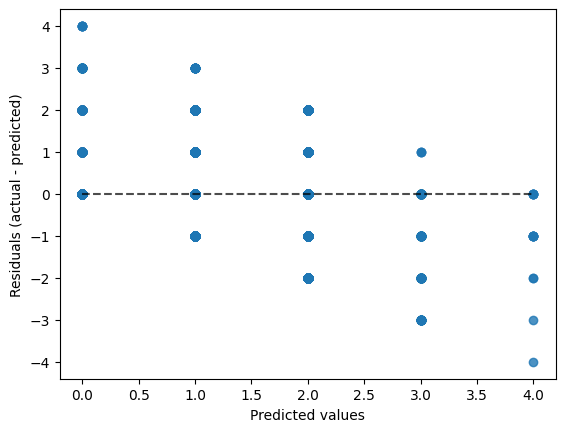

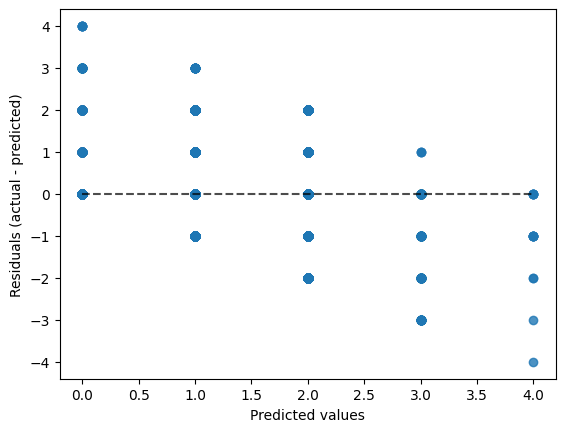

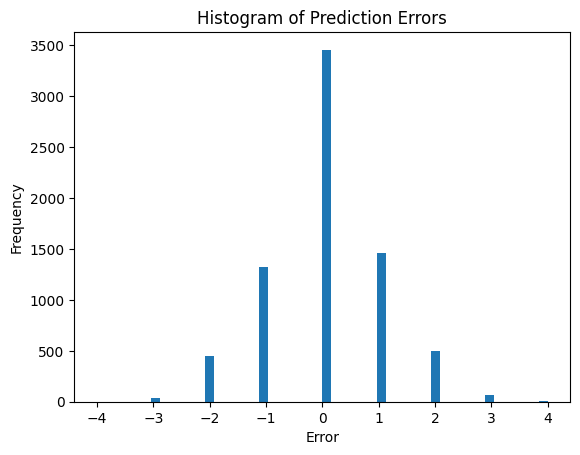

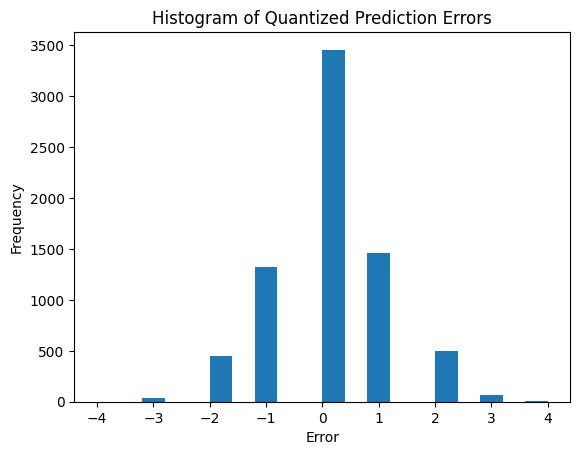

Accuracy: 0.4737491432488006
Confusion Matrix:
[[ 232  833  393   35    1]
 [ 111 1701  437   54    1]
 [ 111  849 1450   48    2]
 [  48  188  496   67    7]
 [   6   19  197    3    6]]


In [52]:
eval_model(ovr_svc,y_test,X_test)

In [53]:
ovo_svc = OneVsOneClassifier(SVC(C = 1.0, max_iter=1000000, random_state=0))
ovo_svc.fit(X_train, y_train)

OneVsOneClassifier(estimator=SVC(max_iter=1000000, random_state=0))

[[1 2 2]
 [0 2 2]
 [4 2 2]
 ...
 [1 1 1]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.9909805723925635
Mean absolute error (cts): 0.674982864976011
R2 score (cts): 0.08039704260964398
Max error (quantized): 4
RMS error (quantized): 0.9909805723925635
Mean absolute error (quantized): 0.674982864976011
R2 score (quantized): 0.08039704260964398


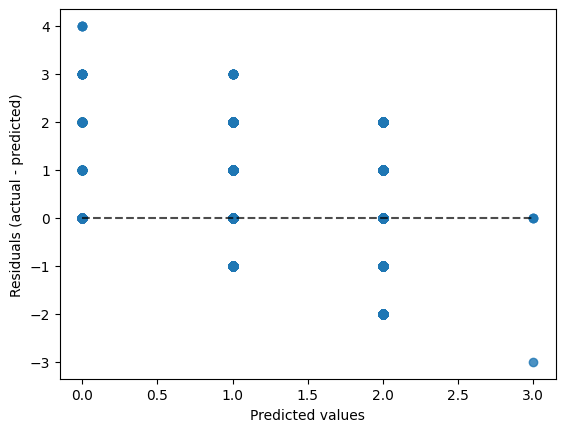

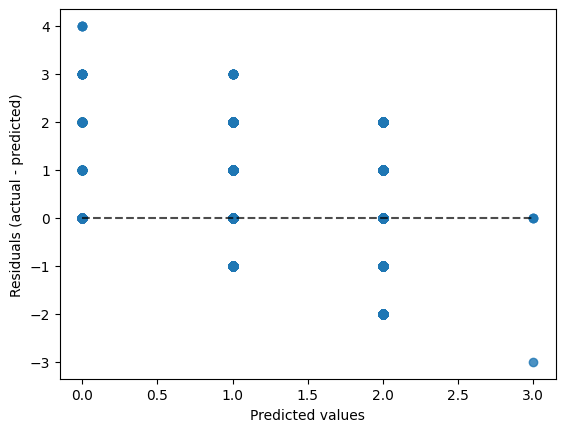

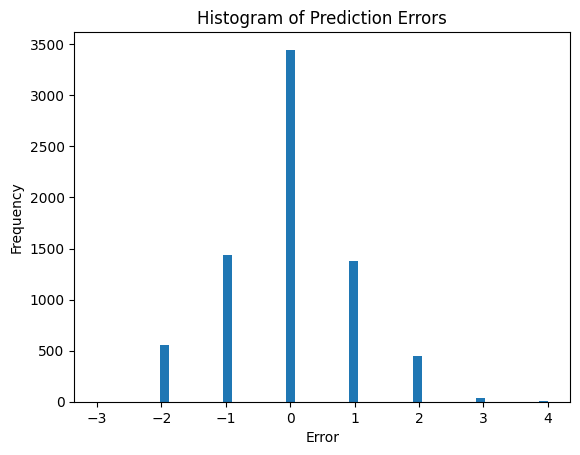

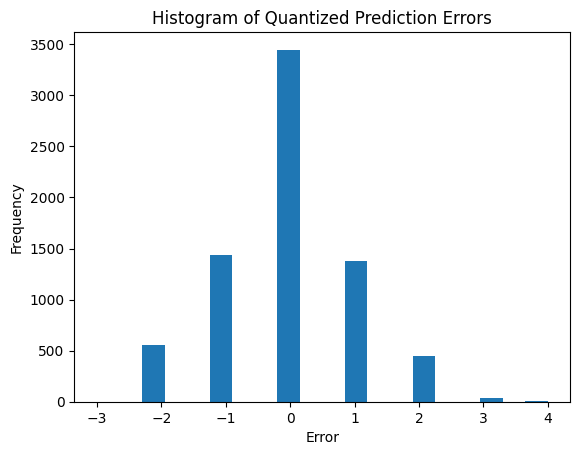

Accuracy: 0.4723783413296779
Confusion Matrix:
[[ 140  801  552    1    0]
 [  41 1625  638    0    0]
 [  66  716 1678    0    0]
 [  17  167  619    3    0]
 [   4   15  212    0    0]]


In [54]:
eval_model(ovo_svc,y_test,X_test)

In [56]:
svc = SVC(C = 1.0, max_iter=1000000, random_state=0)
svc.fit(X_train, y_train)

SVC(max_iter=1000000, random_state=0)

[[1 2 2]
 [0 2 2]
 [4 2 2]
 ...
 [1 1 1]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.995328361371244
Mean absolute error (cts): 0.6767649074708705
R2 score (cts): 0.07231008192907551
Max error (quantized): 4
RMS error (quantized): 0.995328361371244
Mean absolute error (quantized): 0.6767649074708705
R2 score (quantized): 0.07231008192907551


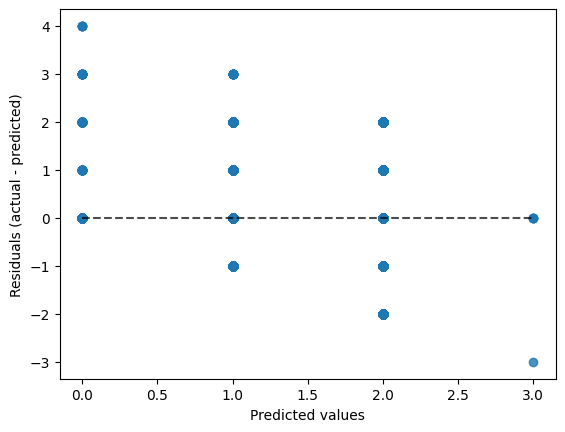

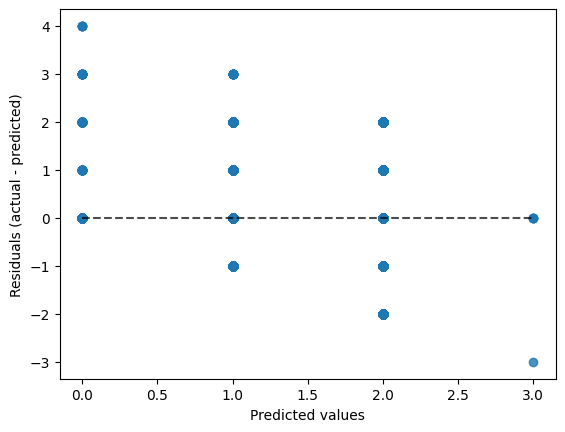

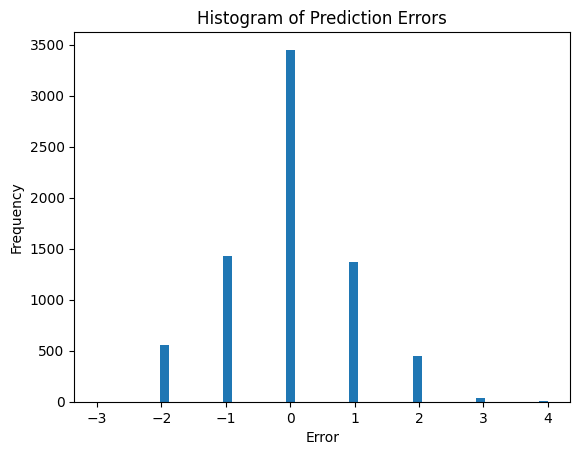

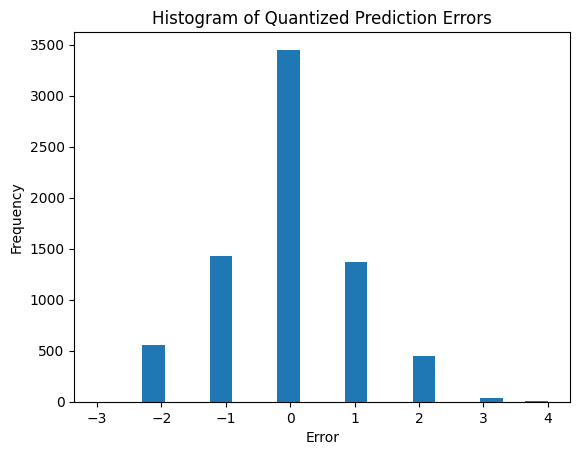

Accuracy: 0.47278958190541465
Confusion Matrix:
[[ 145  796  552    1    0]
 [  44 1625  635    0    0]
 [  69  716 1675    0    0]
 [  23  166  613    4    0]
 [   5   15  211    0    0]]


In [57]:
eval_model(svc,y_test,X_test)

In [58]:
cstep = 0.1
gstep = 0.1
parameters = [{'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['linear'], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['poly'], 'degree': [2, 3, 4], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['sigmoid'], 'gamma': ['scale'], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['sigmoid'], 'gamma': np.arange(gstep,1+gstep,gstep), 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['rbf'], 'gamma': ['scale'], 'max_iter': [100000]},
              {'C': np.arange(cstep,1+cstep,cstep), 'kernel': ['rbf'], 'gamma': np.arange(gstep,1+gstep,gstep), 'max_iter': [100000]}]
svc_grid_search = GridSearchCV(estimator = svc,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 4)
svc_grid_search.fit(X_train, y_train)
best_score = svc_grid_search.best_score_
best_parameters = svc_grid_search.best_params_
cv_results = pd.DataFrame(svc_grid_search.cv_results_)
print("Best Score: {:.2f}".format(best_score*100))
print("Best Parameters:", best_parameters)
print("Cross-Validation Results:\n", cv_results)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits
[CV 5/5] END C=0.4, kernel=linear, max_iter=100000;, score=0.472 total time=  47.8s
[CV 3/5] END C=0.8, kernel=linear, max_iter=100000;, score=0.468 total time=  50.2s
[CV 1/5] END C=0.2, degree=3, kernel=poly, max_iter=100000;, score=0.479 total time=  49.6s
[CV 5/5] END C=0.4, degree=2, kernel=poly, max_iter=100000;, score=0.470 total time=  48.5s


/home/mmccool/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END C=0.4, kernel=linear, max_iter=100000;, score=0.463 total time=  48.3s
[CV 4/5] END C=0.8, kernel=linear, max_iter=100000;, score=0.465 total time=  49.9s
[CV 3/5] END C=0.2, degree=3, kernel=poly, max_iter=100000;, score=0.478 total time=  50.4s
[CV 2/5] END C=0.4, degree=3, kernel=poly, max_iter=100000;, score=0.478 total time=  54.1s
[CV 1/5] END C=0.2, kernel=linear, max_iter=100000;, score=0.469 total time=  44.2s
[CV 3/5] END C=0.7000000000000001, kernel=linear, max_iter=100000;, score=0.468 total time=  48.5s
[CV 5/5] END C=0.1, degree=4, kernel=poly, max_iter=100000;, score=0.488 total time=  52.1s
[CV 5/5] END C=0.30000000000000004, degree=4, kernel=poly, max_iter=100000;, score=0.507 total time=  60.0s
[CV 2/5] END C=0.7000000000000001, kernel=linear, max_iter=100000;, score=0.464 total time= 1.0min
[CV 4/5] END C=1.0, kernel=linear, max_iter=100000;, score=0.464 total time=  50.3s
[CV 4/5] END C=0.2, degree=4, kernel=poly, max_iter=100000;, score=0.496 total tim

/home/mmccool/mambaforge/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Score: 52.91
Best Parameters: {'C': 1.0, 'degree': 4, 'kernel': 'poly', 'max_iter': 100000}
Cross-Validation Results:
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C   
0        41.710148      6.616045         9.411568        1.772230      0.1  \
1        48.887602      9.254282        10.734019        2.160488      0.2   
2        57.675617      0.346290        12.348361        0.055041      0.3   
3        50.917958      9.229901        10.779872        1.956552      0.4   
4        47.987500      9.117452         9.846079        2.098223      0.5   
..             ...           ...              ...             ...      ...   
255      68.207654     10.243504         8.655869        2.363210      1.0   
256      64.129434      9.675230         7.267351        2.189359      1.0   
257      69.569351      5.136256         5.309098        0.449380      1.0   
258      59.810159      7.765577         5.240780        0.247254      1.0   
259      54.657281

### Histogram Gradient Boosting

In [59]:
ovr_hgc = OneVsRestClassifier(HistGradientBoostingClassifier(max_iter = 500, random_state = 0))
ovr_hgc.fit(X_train, y_train)

OneVsRestClassifier(estimator=HistGradientBoostingClassifier(max_iter=500,
                                                             random_state=0))

[[1 1 1]
 [0 0 0]
 [4 4 4]
 ...
 [1 2 2]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.9116562968378407
Mean absolute error (cts): 0.5671007539410555
R2 score (cts): 0.22172630783672131
Max error (quantized): 4
RMS error (quantized): 0.9116562968378407
Mean absolute error (quantized): 0.5671007539410555
R2 score (quantized): 0.22172630783672131


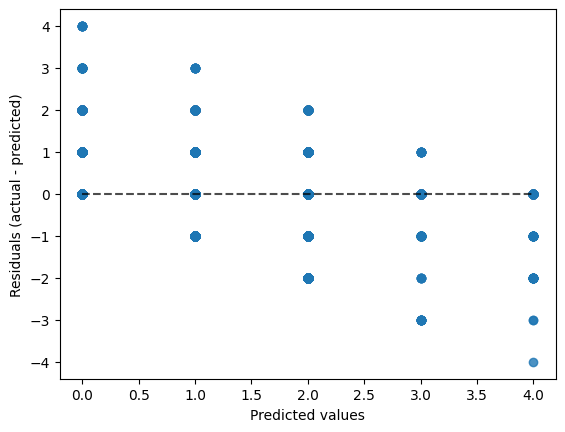

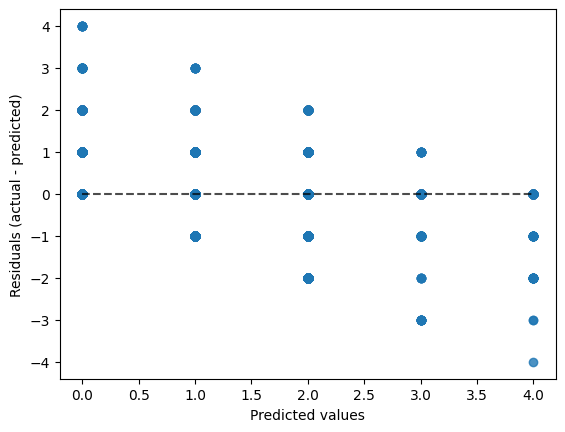

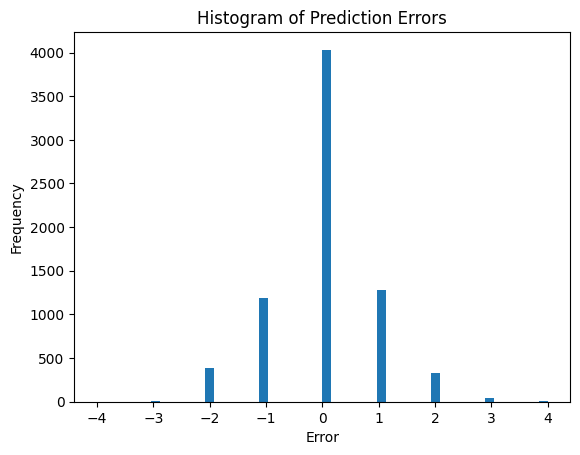

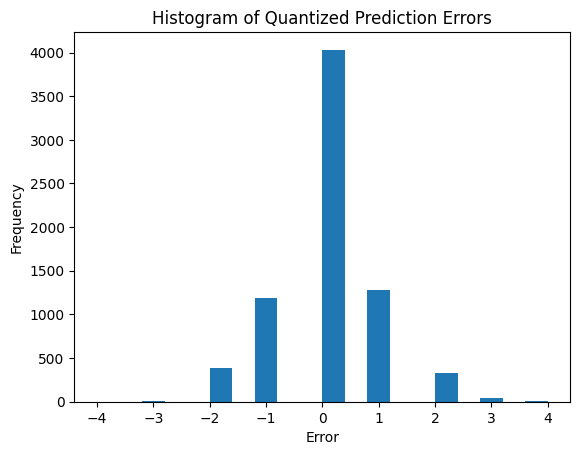

Accuracy: 0.5527073337902673
Confusion Matrix:
[[ 502  616  363   12    1]
 [ 166 1635  496    5    2]
 [ 128  602 1660   48   22]
 [  39  111  506  125   25]
 [   8    9   94   10  110]]


In [60]:
eval_model(ovr_hgc,y_test,X_test)

In [61]:
ovo_hgc = OneVsOneClassifier(HistGradientBoostingClassifier(max_iter = 500, random_state = 0))
ovo_hgc.fit(X_train, y_train)

OneVsOneClassifier(estimator=HistGradientBoostingClassifier(max_iter=500,
                                                            random_state=0))

[[1 1 1]
 [0 2 2]
 [4 4 4]
 ...
 [1 2 2]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.9172028880054799
Mean absolute error (cts): 0.5665524331734064
R2 score (cts): 0.21222733814843453
Max error (quantized): 4
RMS error (quantized): 0.9172028880054799
Mean absolute error (quantized): 0.5665524331734064
R2 score (quantized): 0.21222733814843453


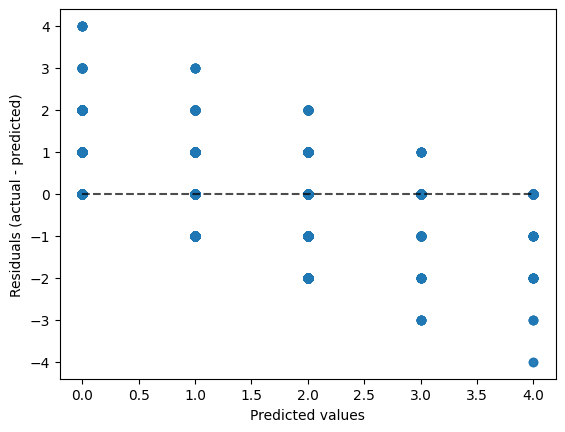

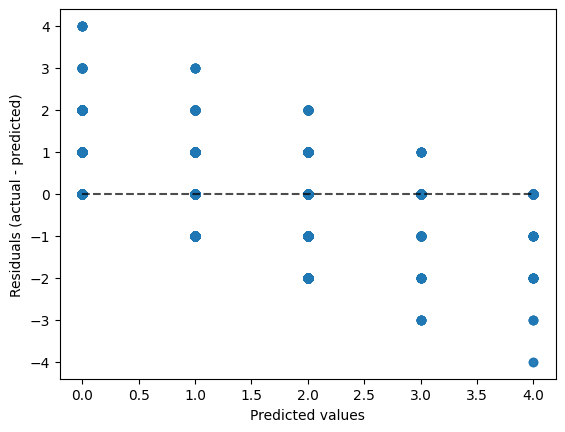

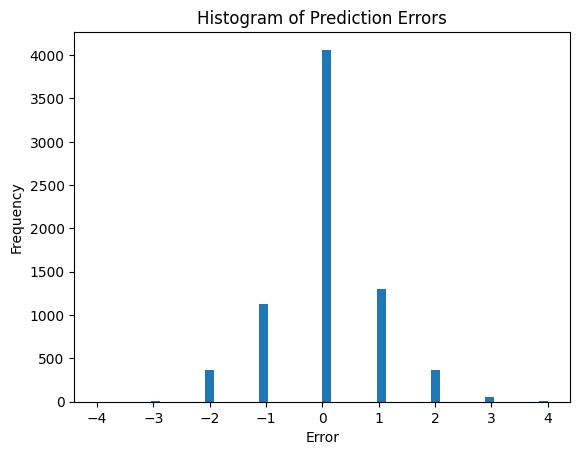

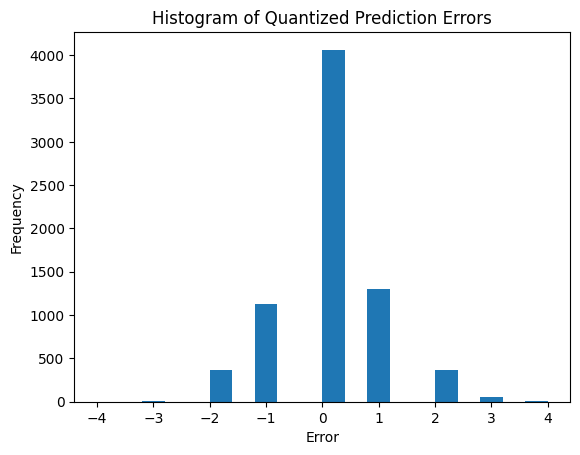

Accuracy: 0.5569568197395476
Confusion Matrix:
[[ 581  576  327    8    2]
 [ 231 1582  465   22    4]
 [ 187  565 1623   63   22]
 [  48   97  487  153   21]
 [   9    8   77   13  124]]


In [62]:
eval_model(ovo_hgc,y_test,X_test)

### Random Forest

In [63]:
ovr_rfc_gini = OneVsRestClassifier(RandomForestClassifier(n_estimators = 500, criterion="gini", random_state = 0))
ovr_rfc_gini.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=500,
                                                     random_state=0))

[[1 2 2]
 [0 2 2]
 [4 4 4]
 ...
 [1 2 2]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.8834786996574722
Mean absolute error (cts): 0.5592871830020562
R2 score (cts): 0.2690927918229079
Max error (quantized): 4
RMS error (quantized): 0.8834786996574722
Mean absolute error (quantized): 0.5592871830020562
R2 score (quantized): 0.2690927918229079


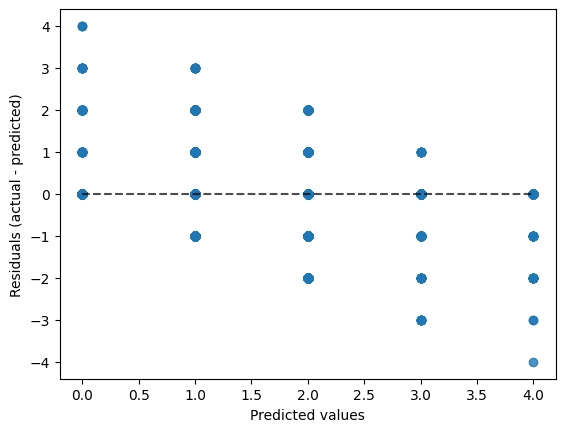

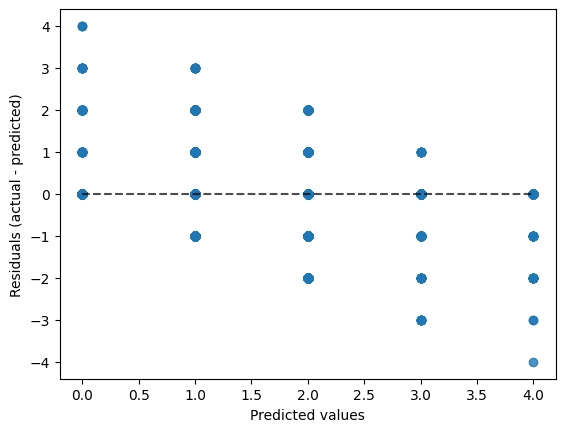

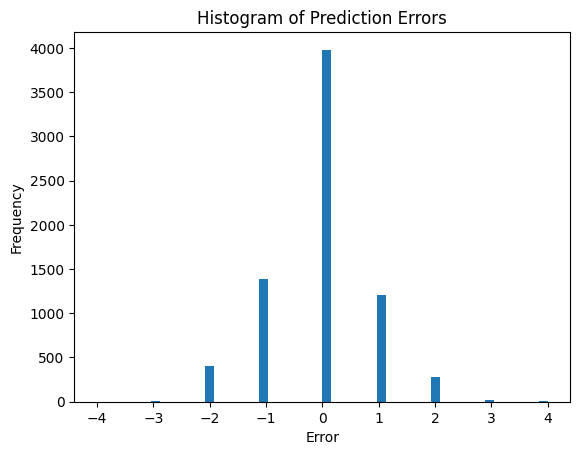

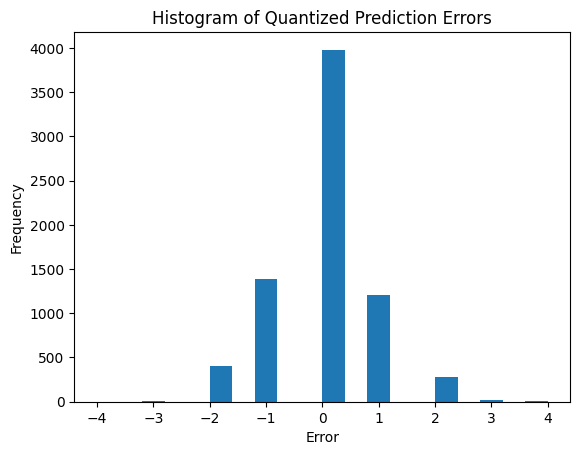

Accuracy: 0.5454420836189171
Confusion Matrix:
[[ 276  825  383    9    1]
 [  30 1781  478   13    2]
 [  50  681 1649   69   11]
 [  10  133  484  164   15]
 [   3   10  100    9  109]]


In [64]:
eval_model(ovr_rfc_gini,y_test,X_test)

In [65]:
ovr_rfc_entropy = OneVsRestClassifier(RandomForestClassifier(n_estimators = 500, criterion="entropy", random_state = 0))
ovr_rfc_entropy.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     n_estimators=500,
                                                     random_state=0))

[[1 2 2]
 [0 2 2]
 [4 4 4]
 ...
 [1 2 2]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.877953255659256
Mean absolute error (cts): 0.5555860178204249
R2 score (cts): 0.27820666814545336
Max error (quantized): 4
RMS error (quantized): 0.877953255659256
Mean absolute error (quantized): 0.5555860178204249
R2 score (quantized): 0.27820666814545336


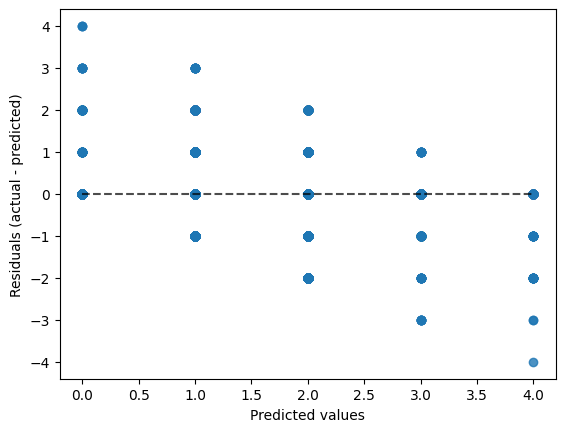

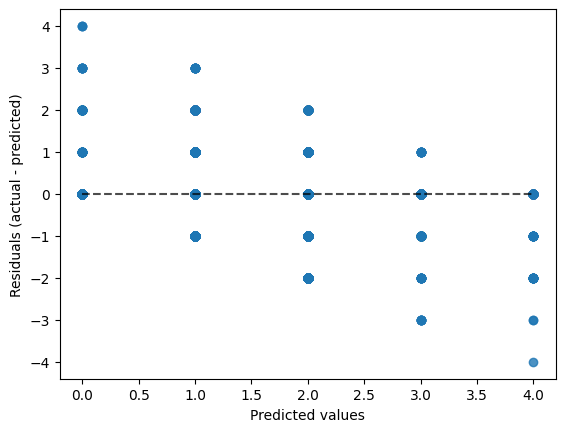

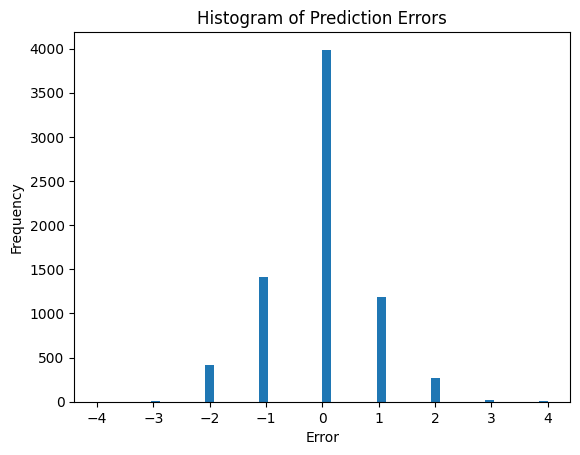

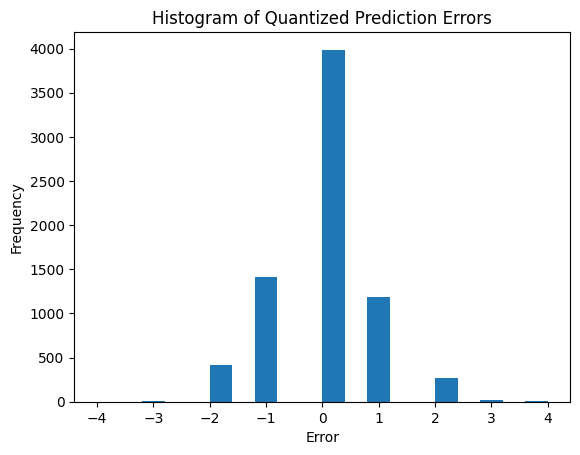

Accuracy: 0.5465387251542152
Confusion Matrix:
[[ 256  845  385    7    1]
 [  25 1785  480   12    2]
 [  46  662 1670   67   15]
 [   8  126  493  162   17]
 [   3   11   93   10  114]]


In [66]:
eval_model(ovr_rfc_entropy,y_test,X_test)

In [67]:
ovo_rfc_gini= OneVsOneClassifier(RandomForestClassifier(n_estimators = 500, criterion="gini", random_state = 0))
ovo_rfc_gini.fit(X_train, y_train)

OneVsOneClassifier(estimator=RandomForestClassifier(n_estimators=500,
                                                    random_state=0))

[[1 1 1]
 [0 2 2]
 [4 4 4]
 ...
 [1 1 1]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.8968760037715318
Mean absolute error (cts): 0.5672378341329678
R2 score (cts): 0.24675737660990937
Max error (quantized): 4
RMS error (quantized): 0.8968760037715318
Mean absolute error (quantized): 0.5672378341329678
R2 score (quantized): 0.24675737660990937


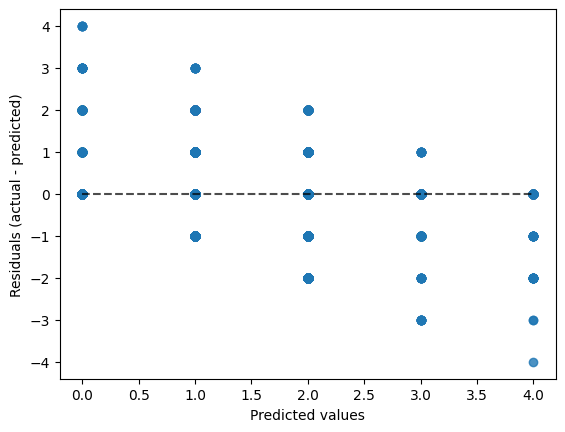

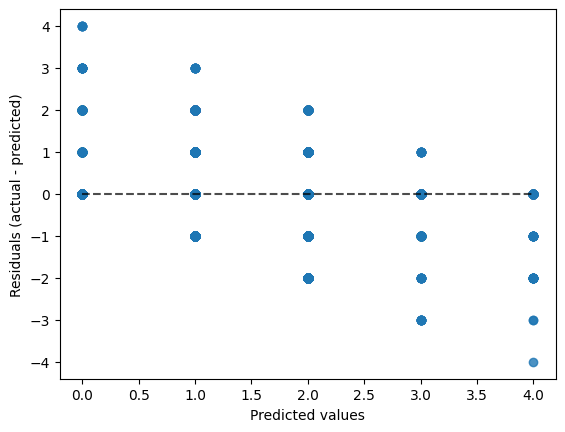

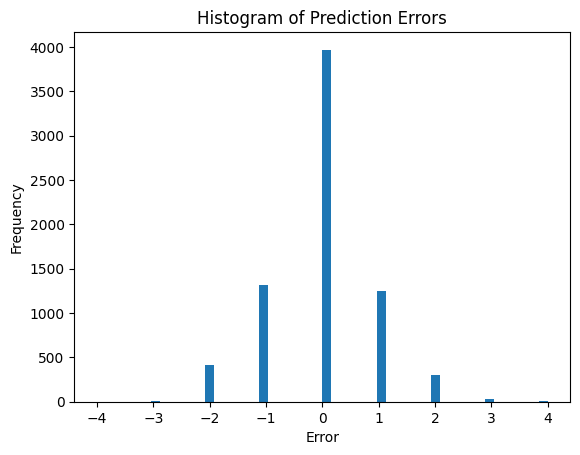

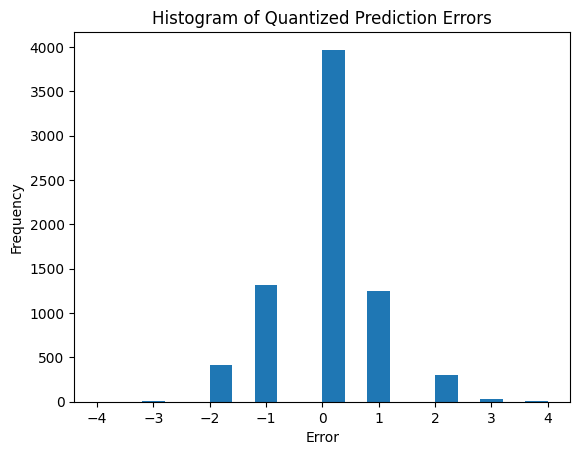

Accuracy: 0.5437971213159698
Confusion Matrix:
[[ 320  775  389    9    1]
 [  60 1767  465   10    2]
 [  72  683 1622   67   16]
 [  17  130  495  151   13]
 [   5    9  101    9  107]]


In [68]:
eval_model(ovo_rfc_gini,y_test,X_test)

In [69]:
ovo_rfc_entropy= OneVsOneClassifier(RandomForestClassifier(n_estimators = 500, criterion="entropy", random_state = 0))
ovo_rfc_entropy.fit(X_train, y_train)

OneVsOneClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                    n_estimators=500,
                                                    random_state=0))

[[1 2 2]
 [0 2 2]
 [4 4 4]
 ...
 [1 2 2]
 [2 2 2]
 [0 2 2]]
Max error (cts): 4
RMS error (cts): 0.8925861725313168
Mean absolute error (cts): 0.5642220699108978
R2 score (cts): 0.25394578610374796
Max error (quantized): 4
RMS error (quantized): 0.8925861725313168
Mean absolute error (quantized): 0.5642220699108978
R2 score (quantized): 0.25394578610374796


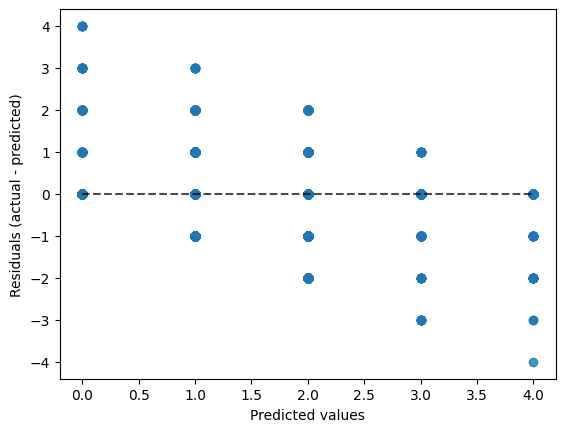

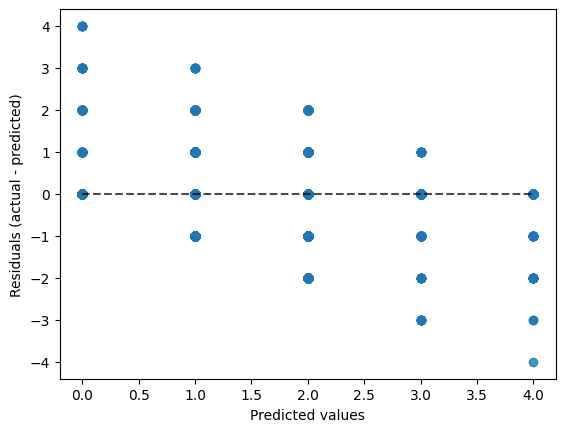

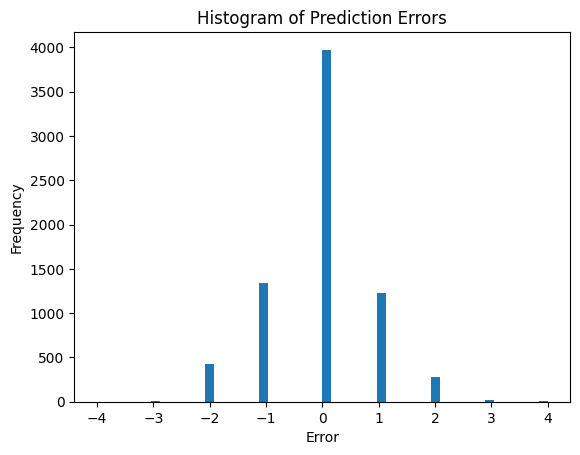

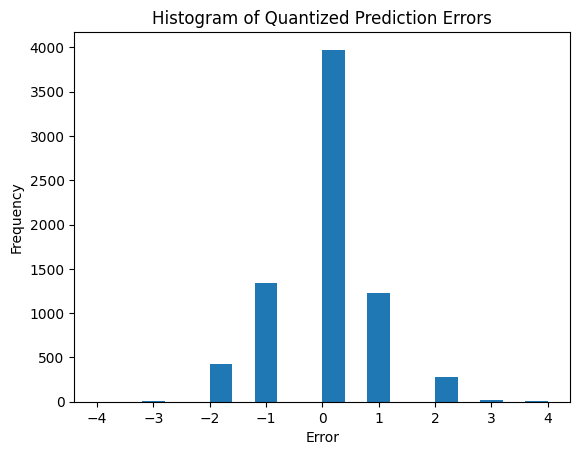

Accuracy: 0.5447566826593557
Confusion Matrix:
[[ 304  776  405    8    1]
 [  48 1760  486    8    2]
 [  63  660 1660   62   15]
 [  15  120  513  141   17]
 [   6    7   99   10  109]]


In [70]:
eval_model(ovo_rfc_entropy,y_test,X_test)